# DESeq1
# Phase 2 vs. Phase 2

focusing on pairwise comparisons of oysters that experienced both phase 1 and phase 2

## 0. load libraries

In [2]:
library(tidyverse)
library(DESeq2)
library(EnhancedVolcano) # for volcano plots
library(vegan) # for permanova
library(pheatmap)
library(RColorBrewer)

## 1. read counts matrix and meta data

### counts matrix

In [3]:
# counts matrix
counts <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ce24_rnaseq/featureCounts/featureCounts_matrix.csv')

# set gene_ID as row name
rownames(counts) <- counts$Gene_ID

# remove gene id and length
counts.df <- counts %>%
select(-Gene_ID, -Length)

head(counts.df)

B1_B1_O01 B1_Nu_O03 B1_W5_O50 B2_B5_O51 B2_C4_O40 B2_Nu_O12
LOC111116054   2         1         6        10         9        16      
LOC111126949 885       652       477       654       586       523      
LOC111110729  64       209        93        63       100       177      
LOC111112434  11         7         2         0         2         2      
LOC111120752 360       586       336       426       351       417      
LOC111128944   0         0         0         0         0         0      
             B3_B4_O41 B3_C3_O30 B3_C6_O66 B3_H4_O41 ⋯ W5_C4_G45 W5_H4_G46
LOC111116054   0        10        22         9       ⋯   9         2      
LOC111126949 392       357       496       540       ⋯ 407       740      
LOC111110729  76        98       235       181       ⋯  70       149      
LOC111112434  12        15        10        36       ⋯  11         6      
LOC111120752 236       278       761       373       ⋯ 359       345      
LOC111128944   0         0         0         0       ⋯   0         0      
             W5_W2_G22 W6_B3_G35 W6_B4_G48 W6_H6_G71 W6_Nu_G41 W6_Nu_G45
LOC111116054   8         5         2        19         1         2      
LOC111126949 707       406       418       424       492       330      
LOC111110729 121       115       126       108       118       115      
LOC111112434   4         0         2        16        22         0      
LOC111120752 438       278       287       416       621       251      
LOC111128944   0         0         0         0         0         1      
             W6_W3_G36 W6_W4_G48
LOC111116054   1         0      
LOC111126949 281       599      
LOC111110729 127       213      
LOC111112434   8         0      
LOC111120752 333       430      
LOC111128944   0         0

In [4]:
# number of genes with 0 counts for all samples
sum(rowSums(counts.df) == 0) # 3372 genes

# pre-filter those rows
counts.filtered <- counts.df[!rowSums(counts.df) == 0,]

# double check this worked
dim(counts.df) # 38838 total genes
dim(counts.filtered) # 35466 genes with at least 1 read

[1] 3372

[1] 38838   120

[1] 35466   120

### meta data
the meta data csv was already generated in [deseq_p1.v.p1](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase1_v_phase1/deseq_p1.v.p1.ipynb), so just reading in here

In [5]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/sample_metaData.csv') %>%
filter(!grepl("Nu", Sample)) # filter out phase 1 samples - only want phase 2

# setting samples as rownames and deleting col from df
rownames(meta) <- meta$Sample
meta <- meta[, !colnames(meta) %in% "Sample"]

head(meta)
dim(meta)

Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 both             warm        hypoxic   1             
B2_B5_O51 both             warm        hypoxic   2             
B2_C4_O40 both             warm        hypoxic   2             
B3_B4_O41 both             warm        hypoxic   3             
B3_C3_O30 both             warm        hypoxic   3             
          Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 warm             warm        normoxic  5             
B2_B5_O51 both             warm        hypoxic   5             
B2_C4_O40 control          ambient     normoxic  4             
B3_B4_O41 both             warm        hypoxic   4             
B3_C3_O30 control          ambient     normoxic  3

[1] 96  8

creating new column for 'complete' treatment - so I can easily compare phase 1 to phase 2

In [6]:
meta$complete_trtmt <- paste(meta$Phase1_treatment, meta$Phase2_treatment)

# check
head(meta,2)
tail(meta,2)

Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 both             warm        hypoxic   1             
          Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep complete_trtmt
B1_B1_O01 both             warm        hypoxic   1              both both     
B1_W5_O50 warm             warm        normoxic  5              both warm

Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
W6_W3_G36 warm             warm        normoxic  6             
W6_W4_G48 warm             warm        normoxic  6             
          Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep complete_trtmt
W6_W3_G36 warm             warm        normoxic  3              warm warm     
W6_W4_G48 warm             warm        normoxic  4              warm warm

In [7]:
# setting the same order for counts matrix and meta data
counts.filtered <- counts.filtered[,rownames(meta)]
all(rownames(meta) == colnames(counts.filtered))

[1] TRUE

## 2. DESeq2
analyzing differential gene expression with [`DESeq2`](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)

#### contrasts
setting up contrasts (telling DESeq what is the control treatment)

In [8]:
# tempature treatments
meta$Phase1_temp <- factor(meta$Phase1_temp,
                                   levels = c('ambient', 'warm'))

meta$Phase2_temp <- factor(meta$Phase2_temp,
                                   levels = c('ambient', 'warm'))

In [9]:
# DO treatments
meta$Phase1_DO <- factor(meta$Phase1_DO,
                                   levels = c('normoxic', 'hypoxic'))

meta$Phase2_DO <- factor(meta$Phase2_DO,
                                   levels = c('normoxic', 'hypoxic'))

### complete treatments
starting simple with looking at phase 1 treatments (not splitting into temperature/DO, just looking at combination of treatments)

In [10]:
# creating DESeq2 object
dds <- DESeqDataSetFromMatrix(countData = counts.filtered,
                              colData = meta,
                              design = ~ complete_trtmt)
dds

# running DESeq
dds <- DESeq(dds)

# list coefficients
resultsNames(dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



class: DESeqDataSet 
dim: 35466 96 
metadata(1): version
assays(1): counts
rownames(35466): LOC111116054 LOC111126949 ... ND1 ND4L
rowData names(0):
colnames(96): B1_B1_O01 B1_W5_O50 ... W6_W3_G36 W6_W4_G48
colData names(9): Phase1_treatment Phase1_temp ... Phase2_TankRep
  complete_trtmt

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and testing



[1] "Intercept"                                  
 [2] "complete_trtmt_both.control_vs_both.both"   
 [3] "complete_trtmt_both.hypoxic_vs_both.both"   
 [4] "complete_trtmt_both.warm_vs_both.both"      
 [5] "complete_trtmt_control.both_vs_both.both"   
 [6] "complete_trtmt_control.control_vs_both.both"
 [7] "complete_trtmt_control.hypoxic_vs_both.both"
 [8] "complete_trtmt_control.warm_vs_both.both"   
 [9] "complete_trtmt_hypoxic.both_vs_both.both"   
[10] "complete_trtmt_hypoxic.control_vs_both.both"
[11] "complete_trtmt_hypoxic.hypoxic_vs_both.both"
[12] "complete_trtmt_hypoxic.warm_vs_both.both"   
[13] "complete_trtmt_warm.both_vs_both.both"      
[14] "complete_trtmt_warm.control_vs_both.both"   
[15] "complete_trtmt_warm.hypoxic_vs_both.both"   
[16] "complete_trtmt_warm.warm_vs_both.both"

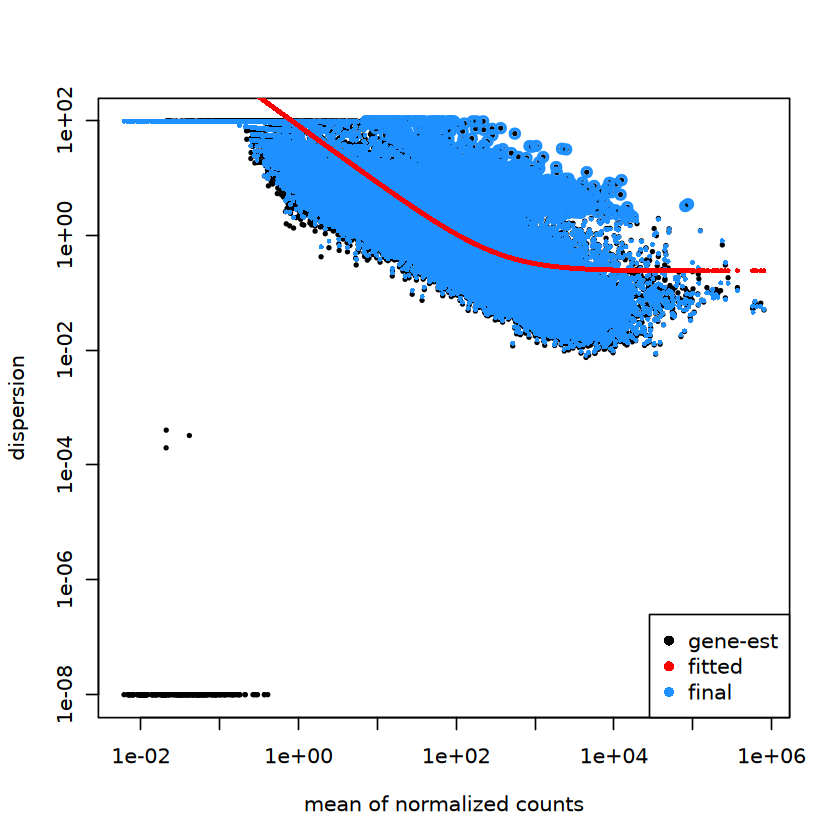

In [15]:
plotDispEsts(dds)

In [16]:
# normalization & transformation
vsd <- vst(dds)

# calculate sample distances
sample_dists <- assay(vsd) %>%
t() %>%
dist() %>%
as.matrix()

head(sample_dists)

# calculate MDS value from distance matrix
mdsData <- data.frame(cmdscale(sample_dists))
mds <- cbind(mdsData, as.data.frame(colData(vsd))) # combine with sample data
head(mds)

B1_B1_O01 B1_W5_O50 B2_B5_O51 B2_C4_O40 B3_B4_O41 B3_C3_O30 B3_C6_O66
B1_B1_O01   0.0000  112.87364 115.3262  107.89794 115.25554 113.48167 122.9179 
B1_W5_O50 112.8736    0.00000 109.3705   92.94934  92.51608  97.48152 101.4467 
B2_B5_O51 115.3262  109.37055   0.0000  115.95337 111.82418 118.24287 112.7788 
B2_C4_O40 107.8979   92.94934 115.9534    0.00000  99.34984  96.00067 108.4873 
B3_B4_O41 115.2555   92.51608 111.8242   99.34984   0.00000 105.68102 108.0776 
B3_C3_O30 113.4817   97.48152 118.2429   96.00067 105.68102   0.00000 114.2894 
          B3_H4_O41 B3_W1_O06 B3_W4_O41 ⋯ W4_W5_G56 W5_B2_G21 W5_C4_G45
B1_B1_O01 116.1678  114.67824 105.7388  ⋯ 131.0135  110.9503   95.3255 
B1_W5_O50 113.4727  106.26615 106.0474  ⋯ 108.4771  117.2177  110.3544 
B2_B5_O51 125.5576  128.07360 123.0549  ⋯ 117.1577  129.0589  121.7444 
B2_C4_O40 111.2476  112.74691 100.7027  ⋯ 114.3448  111.0231  107.5110 
B3_B4_O41 119.5018   97.63448 111.9091  ⋯ 107.0356  120.5420  112.3259 
B3_C3_O30 119.6456  115.27810 111.7599  ⋯ 120.7426  118.9125  108.0603 
          W5_H4_G46 W5_W2_G22 W6_B3_G35 W6_B4_G48 W6_H6_G71 W6_W3_G36 W6_W4_G48
B1_B1_O01 104.5872  101.6345  105.9910  123.9108  108.3290  104.35939 129.5139 
B1_W5_O50 111.4573  111.7282  110.5900  114.0655  110.8031  104.15168 109.1279 
B2_B5_O51 105.0726  118.6173  123.0947  119.5198  123.0654  116.52978 109.4809 
B2_C4_O40 108.3220  106.9164  106.7425  121.0028  105.3548   84.68172 116.2580 
B3_B4_O41 113.9681  117.6559  115.5445  110.0930  115.2253  108.74247 109.6183 
B3_C3_O30 115.0886  114.8697  112.1972  126.0074  108.2107  108.42614 123.0013

X1         X2         Phase1_treatment Phase1_temp Phase1_DO
B1_B1_O01  14.051733  16.698775 both             warm        hypoxic  
B1_W5_O50  -3.585329 -22.358652 both             warm        hypoxic  
B2_B5_O51 -20.966187  -9.778556 both             warm        hypoxic  
B2_C4_O40   6.786560 -11.905661 both             warm        hypoxic  
B3_B4_O41 -11.624562 -19.641997 both             warm        hypoxic  
B3_C3_O30   8.824681  -8.946989 both             warm        hypoxic  
          Phase1_TankRep Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep
B1_B1_O01 1              both             warm        hypoxic   1             
B1_W5_O50 1              warm             warm        normoxic  5             
B2_B5_O51 2              both             warm        hypoxic   5             
B2_C4_O40 2              control          ambient     normoxic  4             
B3_B4_O41 3              both             warm        hypoxic   4             
B3_C3_O30 3              control          ambient     normoxic  3             
          complete_trtmt sizeFactor
B1_B1_O01 both both      1.0714460 
B1_W5_O50 both warm      1.0125468 
B2_B5_O51 both both      1.0641357 
B2_C4_O40 both control   1.1577371 
B3_B4_O41 both both      0.8702869 
B3_C3_O30 both control   0.8565139

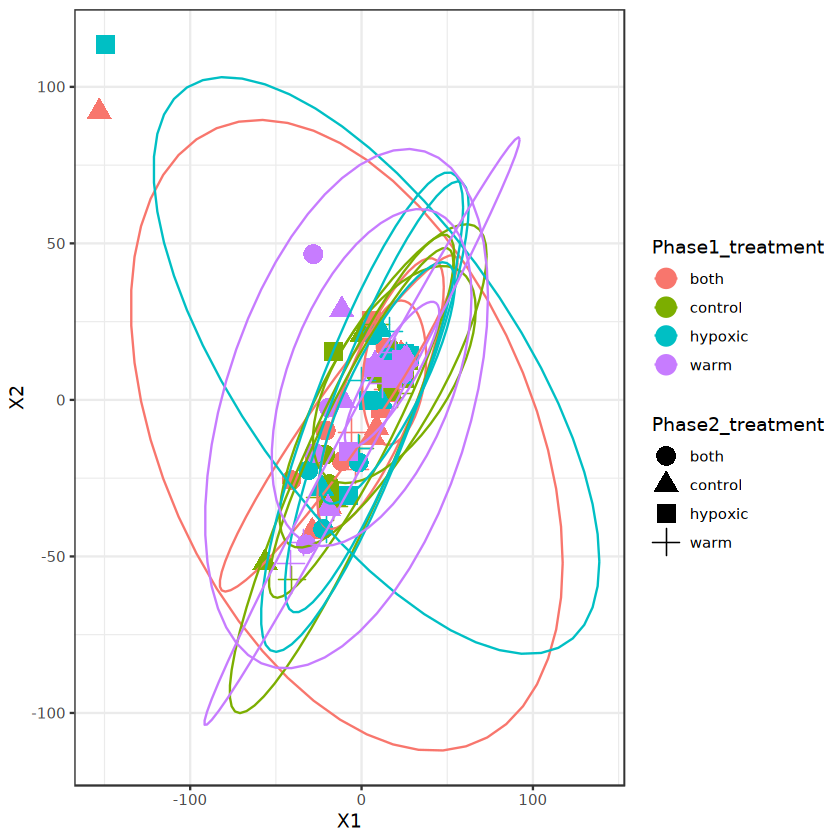

In [17]:
nmds.plot <- ggplot(mds, aes(X1, X2, col = Phase1_treatment, shape = Phase2_treatment)) +
geom_point(size = 5) +
stat_ellipse() + 
theme_bw()

nmds.plot

attempting to make the above plot a little more legible by facetting/coloring and shaping by phase water treatments - but not sure if this actually just makes things more confusing/not the right way to show this

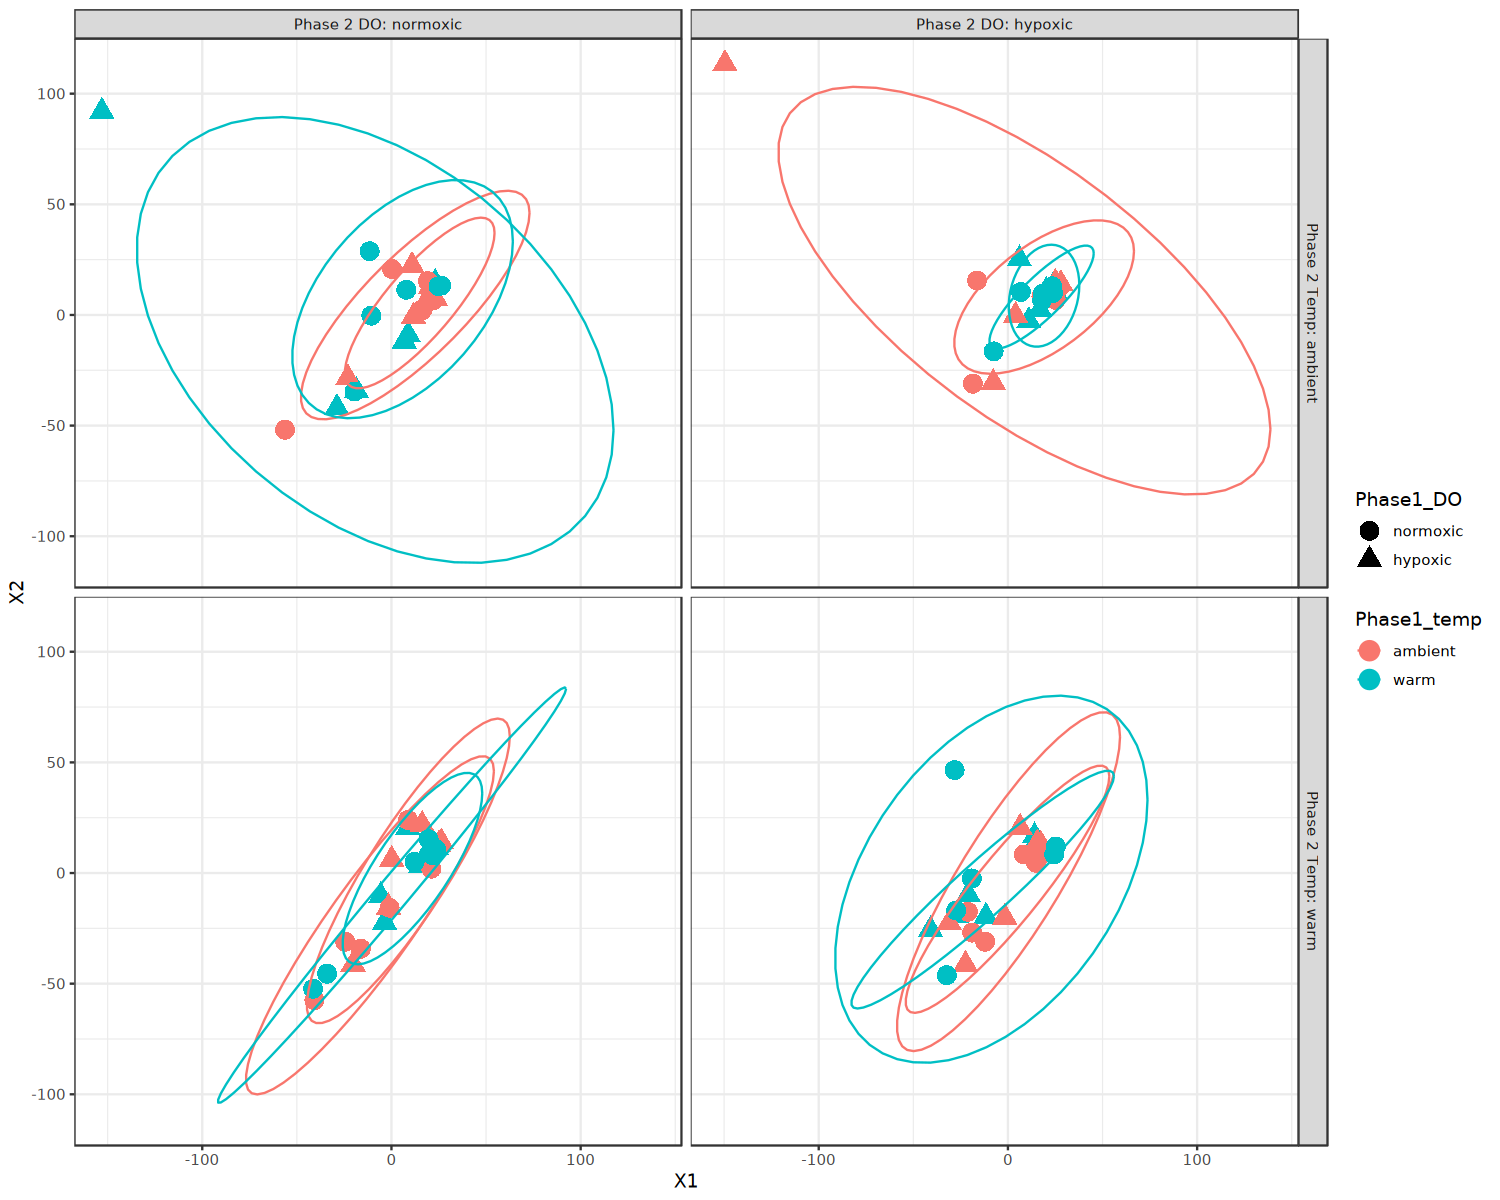

In [18]:
options(repr.plot.width=12.5, repr.plot.height=10)

# faceted by Phase 2 treatment
nmds.plot <- ggplot(mds, aes(X1, X2, col = Phase1_temp, shape = Phase1_DO)) +
geom_point(size = 5) +
stat_ellipse() + 
theme_bw() + 
facet_grid(Phase2_temp ~ Phase2_DO,
           labeller = labeller(
      Phase2_temp = function(x) paste("Phase 2 Temp:", x),
      Phase2_DO   = function(x) paste("Phase 2 DO:", x)
    )
           )

nmds.plot

when phase 2 is normoxic and warm (Warm treatment) - the points are all on top of each other, with very little dispersion

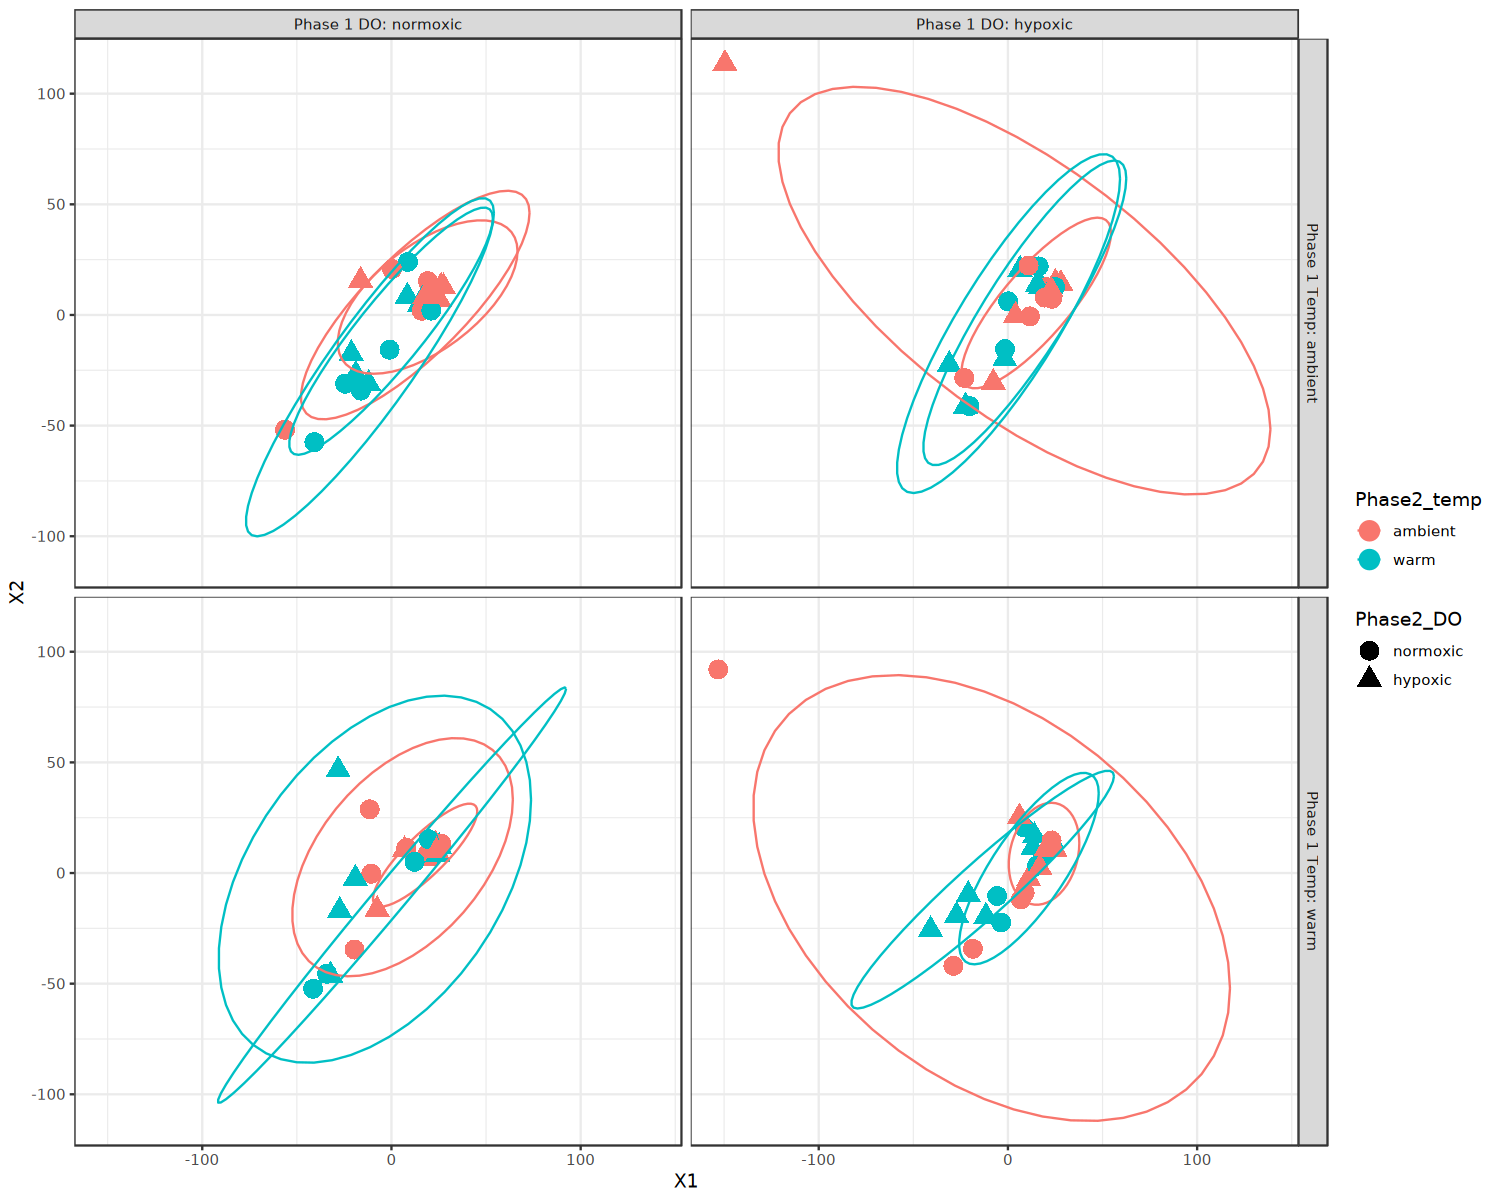

In [24]:
options(repr.plot.width=12.5, repr.plot.height=10)

# faceted by Phase 1 treatment
nmds.plot <- ggplot(mds, aes(X1, X2, col = Phase2_temp, shape = Phase2_DO)) +
geom_point(size = 5) +
stat_ellipse() + 
theme_bw() + 
facet_grid(Phase1_temp ~ Phase1_DO,
           labeller = labeller(
      Phase1_temp = function(x) paste("Phase 1 Temp:", x),
      Phase1_DO   = function(x) paste("Phase 1 DO:", x)
    )
           )

nmds.plot

In [19]:
sample_dists <- dist(t(assay(vsd)))  # transpose so samples are rows
head(sample_dists)

meta <- as.data.frame(colData(vsd))
head(meta)

[1] 112.8736 115.3262 107.8979 115.2555 113.4817 122.9179

Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 both             warm        hypoxic   1             
B2_B5_O51 both             warm        hypoxic   2             
B2_C4_O40 both             warm        hypoxic   2             
B3_B4_O41 both             warm        hypoxic   3             
B3_C3_O30 both             warm        hypoxic   3             
          Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep complete_trtmt
B1_B1_O01 both             warm        hypoxic   1              both both     
B1_W5_O50 warm             warm        normoxic  5              both warm     
B2_B5_O51 both             warm        hypoxic   5              both both     
B2_C4_O40 control          ambient     normoxic  4              both control  
B3_B4_O41 both             warm        hypoxic   4              both both     
B3_C3_O30 control          ambient     normoxic  3              both control  
          sizeFactor
B1_B1_O01 1.0714460 
B1_W5_O50 1.0125468 
B2_B5_O51 1.0641357 
B2_C4_O40 1.1577371 
B3_B4_O41 0.8702869 
B3_C3_O30 0.8565139

In [20]:
adonis2(sample_dists ~ Phase1_temp * Phase1_DO * Phase2_temp * Phase2_DO, data = meta, permutations = 999)

Df SumOfSqs   R2          F        
Phase1_temp                                  1   6436.659 0.009290143 0.8849709
Phase1_DO                                    1   5969.374 0.008615702 0.8207242
Phase2_temp                                  1  13573.403 0.019590729 1.8661956
Phase2_DO                                    1   9153.680 0.013211666 1.2585317
Phase1_temp:Phase1_DO                        1   5134.389 0.007410554 0.7059228
Phase1_temp:Phase2_temp                      1   5290.850 0.007636376 0.7274345
Phase1_DO:Phase2_temp                        1   6350.438 0.009165698 0.8731164
Phase1_temp:Phase2_DO                        1   6029.998 0.008703202 0.8290594
Phase1_DO:Phase2_DO                          1   6800.014 0.009814579 0.9349282
Phase2_temp:Phase2_DO                        1   9477.392 0.013678885 1.3030385
Phase1_temp:Phase1_DO:Phase2_temp            1   6584.395 0.009503372 0.9052828
Phase1_temp:Phase1_DO:Phase2_DO              1   6939.121 0.010015355 0.9540539
Phase1_temp:Phase2_temp:Phase2_DO            1   8889.284 0.012830059 1.2221801
Phase1_DO:Phase2_temp:Phase2_DO              1   8016.276 0.011570032 1.1021510
Phase1_temp:Phase1_DO:Phase2_temp:Phase2_DO  1   6338.892 0.009149034 0.8715289
Residual                                    80 581864.090 0.839814612        NA
Total                                       95 692848.257 1.000000000        NA
                                            Pr(>F)
Phase1_temp                                 0.683 
Phase1_DO                                   0.833 
Phase2_temp                                 0.005 
Phase2_DO                                   0.114 
Phase1_temp:Phase1_DO                       0.978 
Phase1_temp:Phase2_temp                     0.940 
Phase1_DO:Phase2_temp                       0.715 
Phase1_temp:Phase2_DO                       0.792 
Phase1_DO:Phase2_DO                         0.573 
Phase2_temp:Phase2_DO                       0.106 
Phase1_temp:Phase1_DO:Phase2_temp           0.619 
Phase1_temp:Phase1_DO:Phase2_DO             0.518 
Phase1_temp:Phase2_temp:Phase2_DO           0.128 
Phase1_DO:Phase2_temp:Phase2_DO             0.266 
Phase1_temp:Phase1_DO:Phase2_temp:Phase2_DO 0.697 
Residual                                       NA 
Total                                          NA

- Phase2_temp has a significant effect on GE (P = 0.005) and explains ~1.9% of the variation in GE
- The interaction of Phase2_temp and Phase2_DO is nearly significant (P = 0.094) and explains ~1.3% of the variation in GE
- The majoirty of the variation in GE is not explained by the treatments (R2 = 0.84)

#### heatmap of sample-to-sample distances using the variance stabilizing transformed values
following [RNA-seq workflow](https://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html) from Mike Love

In [21]:
# normalization & transformation
vsd <- vst(dds)

# calculate sample distances
sample_dists <- dist(t(assay(vsd)))
head(sample_dists)

[1] 112.8736 115.3262 107.8979 115.2555 113.4817 122.9179

In [27]:
head(vsd)

class: DESeqTransform 
dim: 6 96 
metadata(1): version
assays(1): ''
rownames(6): LOC111116054 LOC111126949 ... LOC111120752 LOC111128944
rowData names(78): baseMean baseVar ... maxCooks dispFit
colnames(96): B1_B1_O01 B1_W5_O50 ... W6_W3_G36 W6_W4_G48
colData names(10): Phase1_treatment Phase1_temp ... complete_trtmt
  sizeFactor

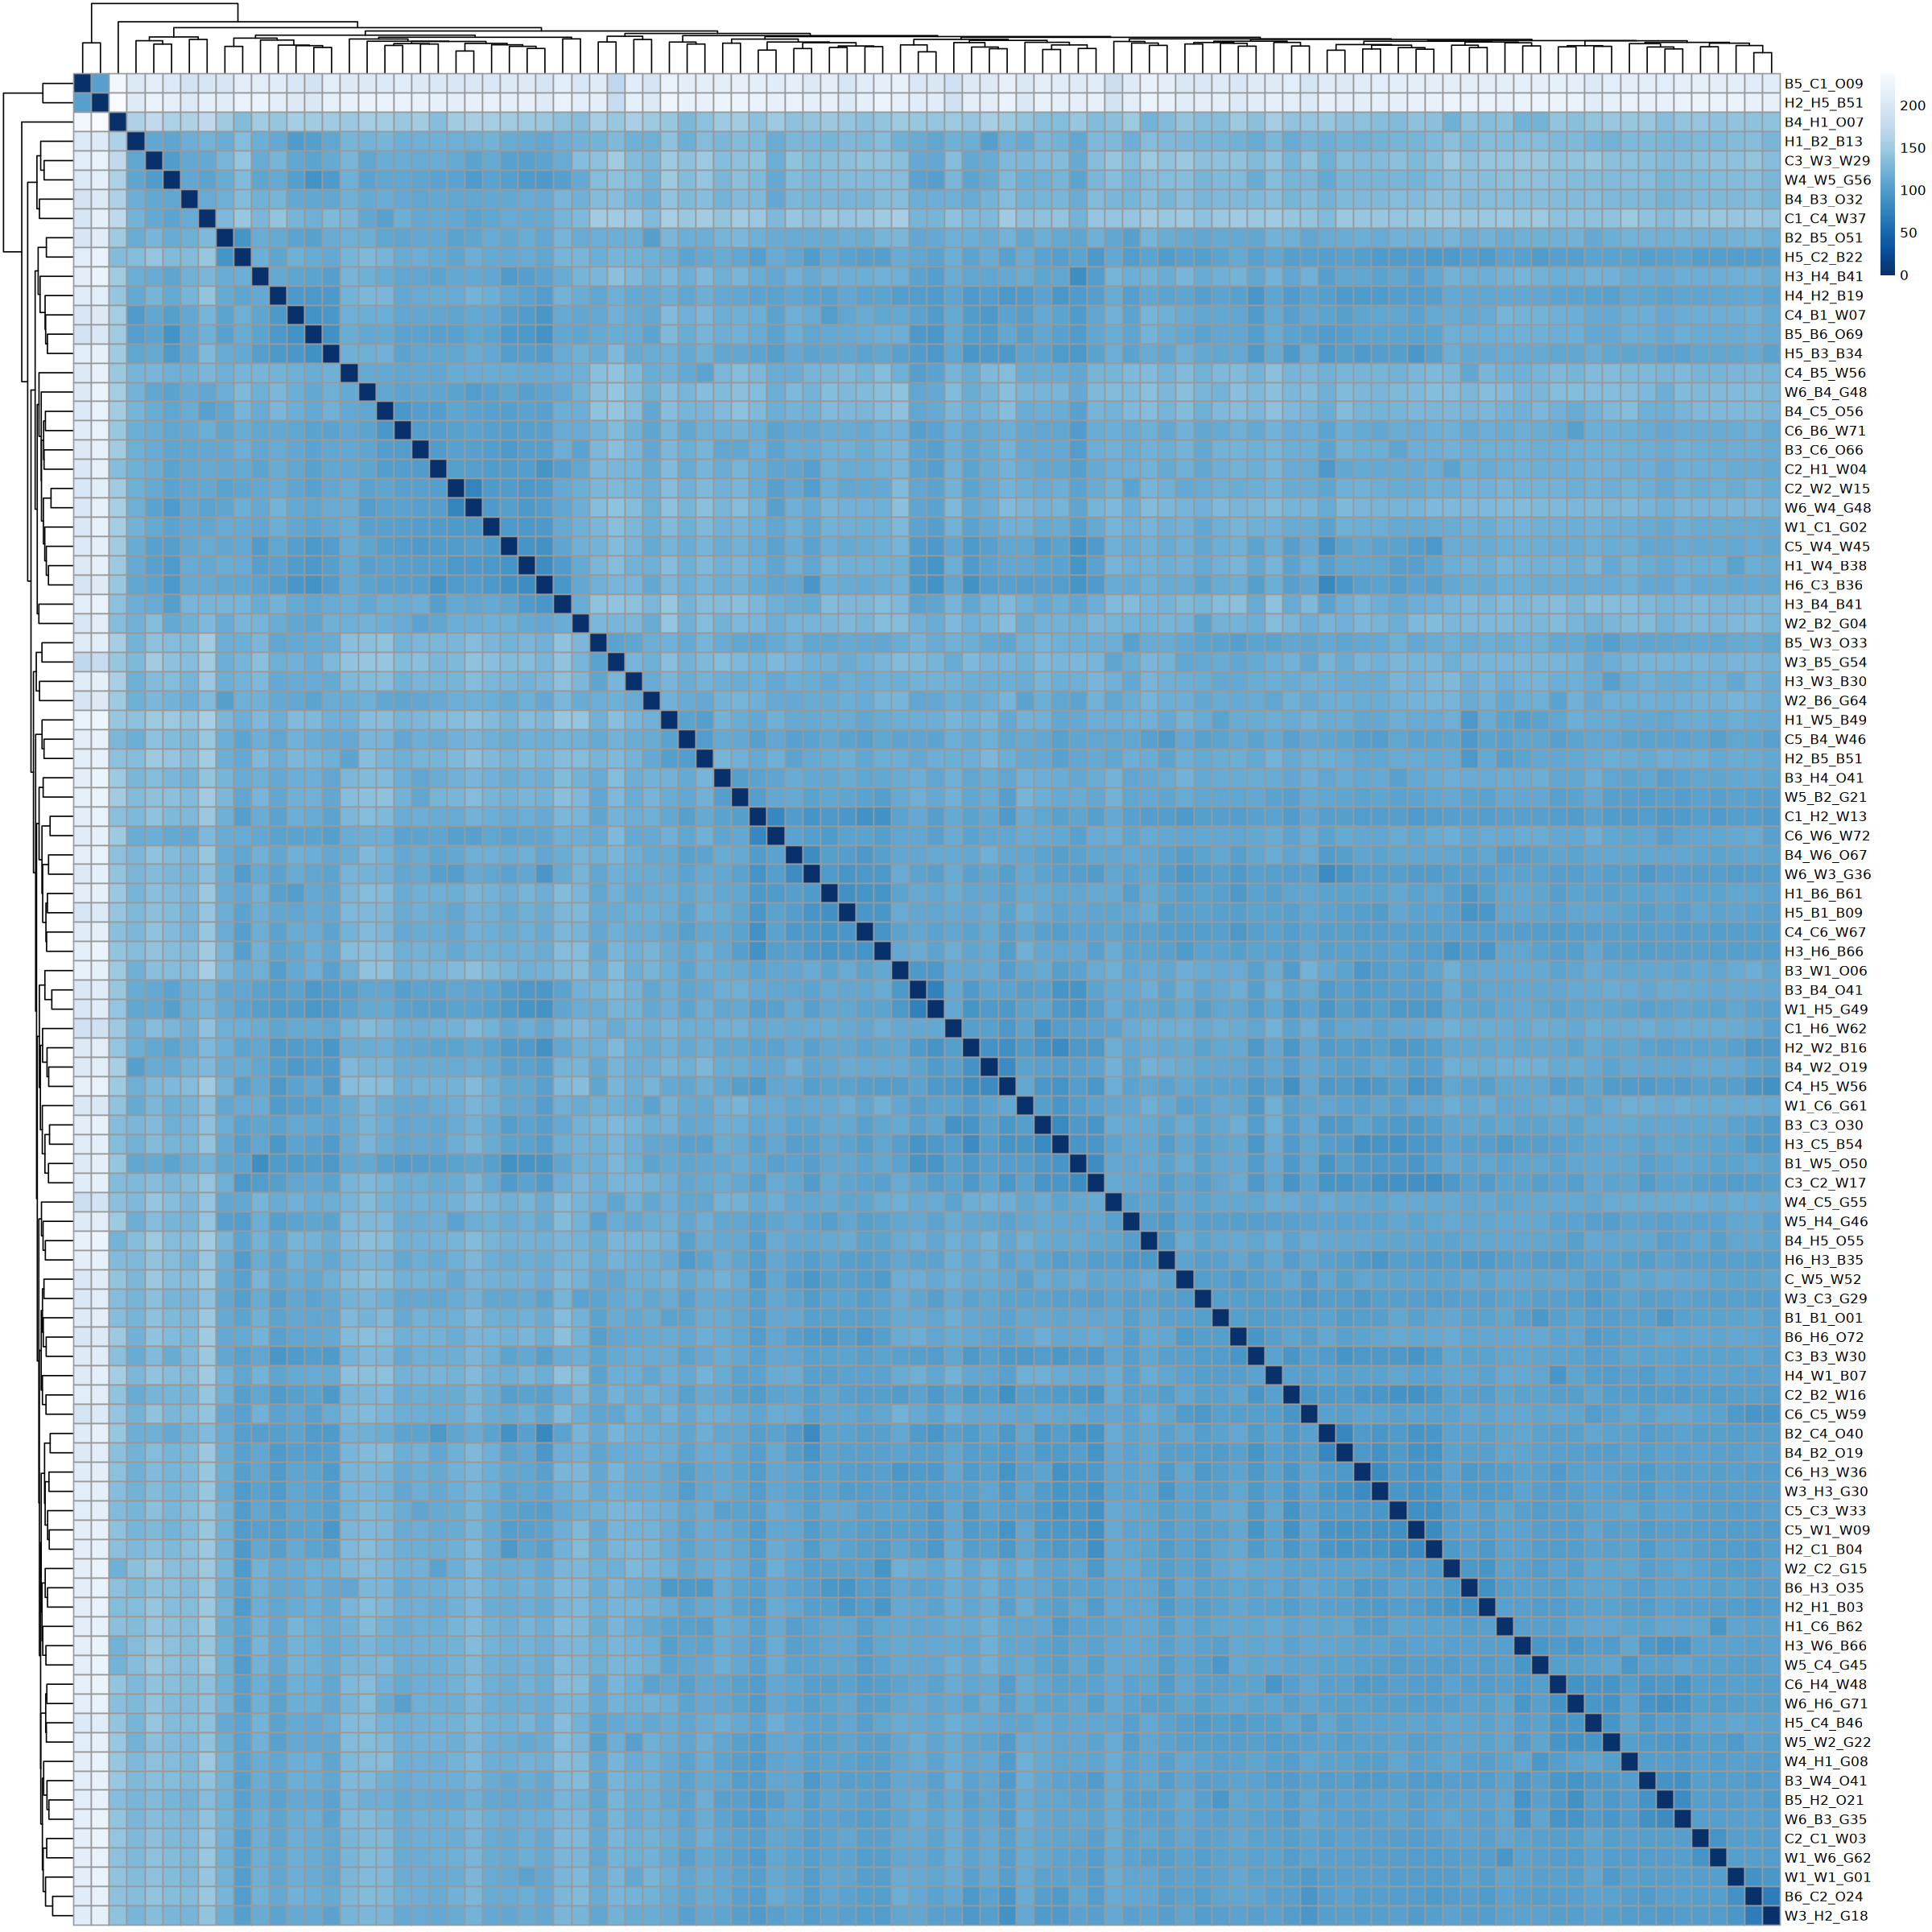

In [28]:
options(repr.plot.width=20, repr.plot.height=20)

sampleDistMatrix <- as.matrix(sample_dists)
rownames(sampleDistMatrix) <- paste(colnames(vsd))
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sample_dists,
         clustering_distance_cols = sample_dists,
         col = colors)

it's weird that there's two samples that are very dissimilar to every other sample, but appear closer together - (HH and BC) - if you look at the nMDS plots too, they look like outliers from their replicates so should consider removing those samples from analysis 

In [25]:
pcaData <- plotPCA(vsd, intgroup = c( "Phase1_treatment", "Phase2_treatment"), returnData = TRUE)
head(pcaData)

using ntop=500 top features by variance



PC1        PC2        group        Phase1_treatment Phase2_treatment
B1_B1_O01 -15.235433  -6.934442 both:both    both             both            
B1_W5_O50  14.849221   9.509118 both:warm    both             warm            
B2_B5_O51  18.444463 -10.028868 both:both    both             both            
B2_C4_O40   3.515344   7.850587 both:control both             control         
B3_B4_O41  17.977723   6.903814 both:both    both             both            
B3_C3_O30   0.971464   8.528714 both:control both             control         
          name     
B1_B1_O01 B1_B1_O01
B1_W5_O50 B1_W5_O50
B2_B5_O51 B2_B5_O51
B2_C4_O40 B2_C4_O40
B3_B4_O41 B3_B4_O41
B3_C3_O30 B3_C3_O30

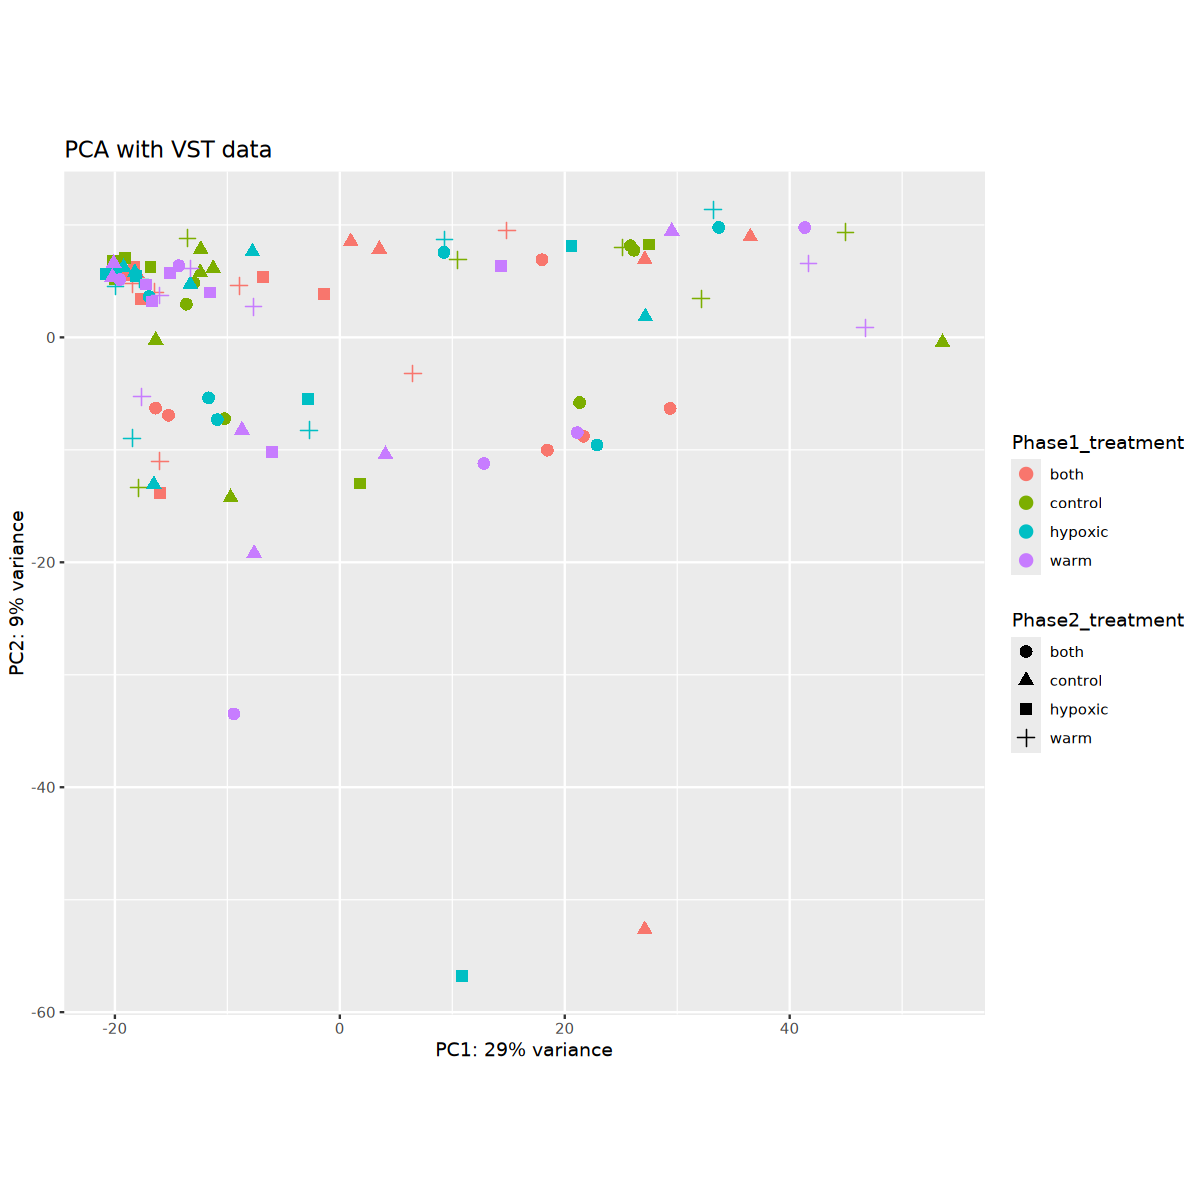

In [26]:
options(repr.plot.width=10, repr.plot.height=10)

percentVar <- round(100 * attr(pcaData, "percentVar"))

ggplot(pcaData, aes(x = PC1, y = PC2, color = Phase1_treatment, shape = Phase2_treatment)) +
  geom_point(size =3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed() +
  ggtitle("PCA with VST data")

there's those two samples again in the bottom of the plot - B5_C1_O09 and H2_H5_B51 - that cluster away from everything else 

what do things look like if I remove those?

In [31]:
# remove two samples
dds_filtered <- dds[, !colnames(dds) %in% c("B5_C1_O09", "H2_H5_B51")]

In [35]:
# normalization & transformation
vsd_filtered <- vst(dds_filtered)

# calculate sample distances
sample_dists_filtered <- dist(t(assay(vsd_filtered)))
head(sample_dists_filtered)

[1] 100.4635 102.6446  96.1057 102.8532 101.2851 109.8069

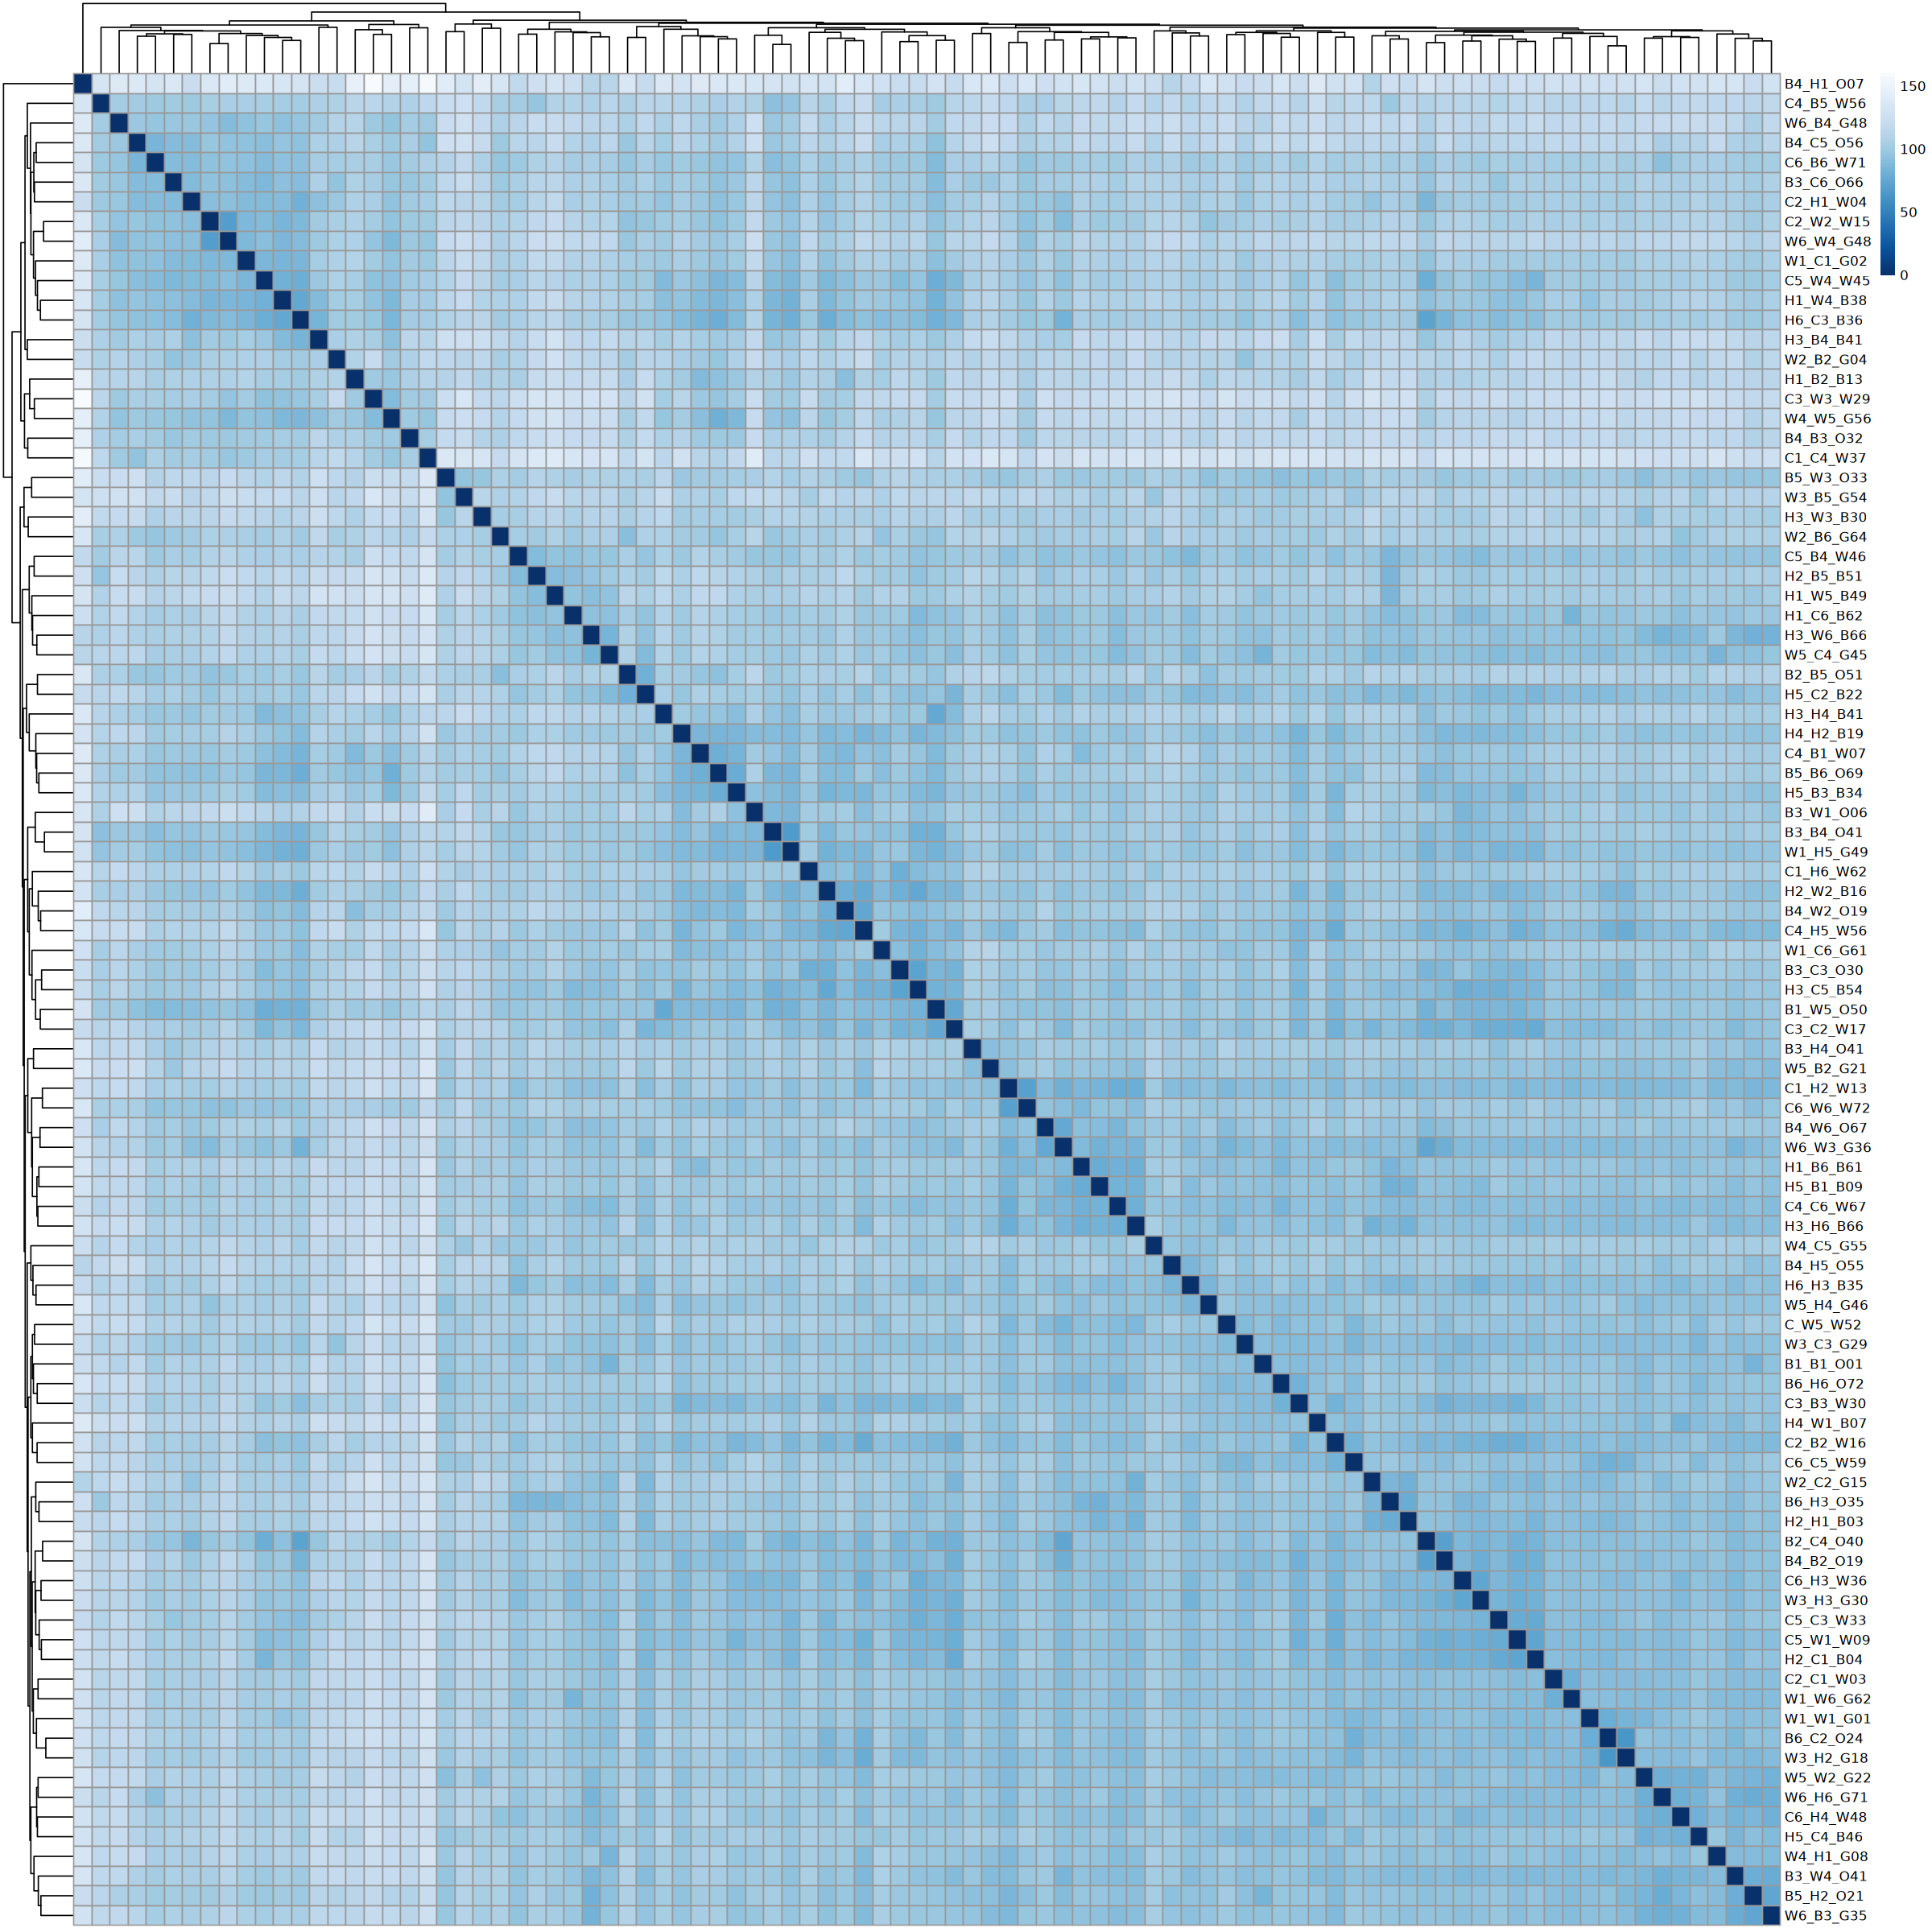

In [36]:
sampleDistMatrix <- as.matrix(sample_dists_filtered)
rownames(sampleDistMatrix) <- paste(colnames(vsd_filtered))
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sample_dists_filtered,
         clustering_distance_cols = sample_dists_filtered,
         col = colors)

In [38]:
pcaData_filtered <- plotPCA(vsd_filtered, intgroup = c( "Phase1_treatment", "Phase2_treatment"), returnData = TRUE)
head(pcaData_filtered)

using ntop=500 top features by variance



PC1        PC2        group        Phase1_treatment Phase2_treatment
B1_B1_O01 -14.037994  -9.929544 both:both    both             both            
B1_W5_O50  14.068852   5.334128 both:warm    both             warm            
B2_B5_O51  16.458371 -13.949316 both:both    both             both            
B2_C4_O40   3.384706   8.147616 both:control both             control         
B3_B4_O41  16.633026   7.726549 both:both    both             both            
B3_C3_O30   1.403774   7.200035 both:control both             control         
          name     
B1_B1_O01 B1_B1_O01
B1_W5_O50 B1_W5_O50
B2_B5_O51 B2_B5_O51
B2_C4_O40 B2_C4_O40
B3_B4_O41 B3_B4_O41
B3_C3_O30 B3_C3_O30

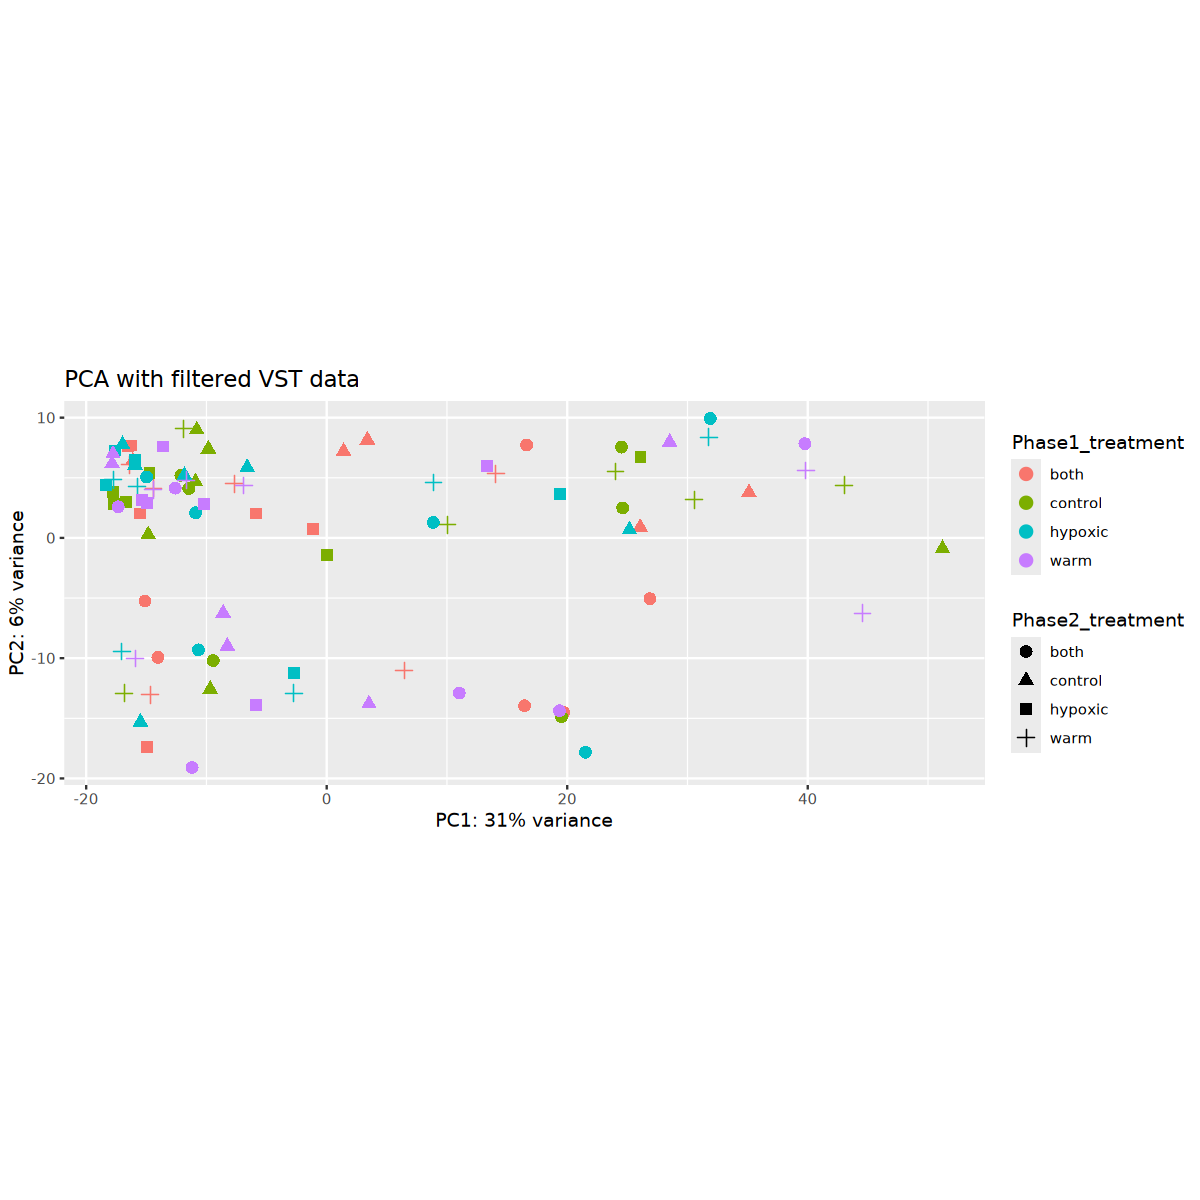

In [40]:
options(repr.plot.width=10, repr.plot.height=10)

percentVar <- round(100 * attr(pcaData_filtered, "percentVar"))

ggplot(pcaData_filtered, aes(x = PC1, y = PC2, color = Phase1_treatment, shape = Phase2_treatment)) +
  geom_point(size =3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed() +
  ggtitle("PCA with filtered VST data")

In [41]:
# calculate MDS value from distance matrix
mdsData_filtered <- data.frame(cmdscale(sample_dists_filtered))
mds_filtered <- cbind(mdsData_filtered, as.data.frame(colData(vsd_filtered))) # combine with sample data
head(mds_filtered)

X1          X2          Phase1_treatment Phase1_temp Phase1_DO
B1_B1_O01  18.4782222   0.9232659 both             warm        hypoxic  
B1_W5_O50 -16.4851013  -5.5134345 both             warm        hypoxic  
B2_B5_O51 -20.4324328  13.5814187 both             warm        hypoxic  
B2_C4_O40  -2.9953080 -12.4303847 both             warm        hypoxic  
B3_B4_O41 -19.8708213  -0.4601782 both             warm        hypoxic  
B3_C3_O30  -0.4961614   1.1268402 both             warm        hypoxic  
          Phase1_TankRep Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep
B1_B1_O01 1              both             warm        hypoxic   1             
B1_W5_O50 1              warm             warm        normoxic  5             
B2_B5_O51 2              both             warm        hypoxic   5             
B2_C4_O40 2              control          ambient     normoxic  4             
B3_B4_O41 3              both             warm        hypoxic   4             
B3_C3_O30 3              control          ambient     normoxic  3             
          complete_trtmt sizeFactor
B1_B1_O01 both both      1.0714460 
B1_W5_O50 both warm      1.0125468 
B2_B5_O51 both both      1.0641357 
B2_C4_O40 both control   1.1577371 
B3_B4_O41 both both      0.8702869 
B3_C3_O30 both control   0.8565139

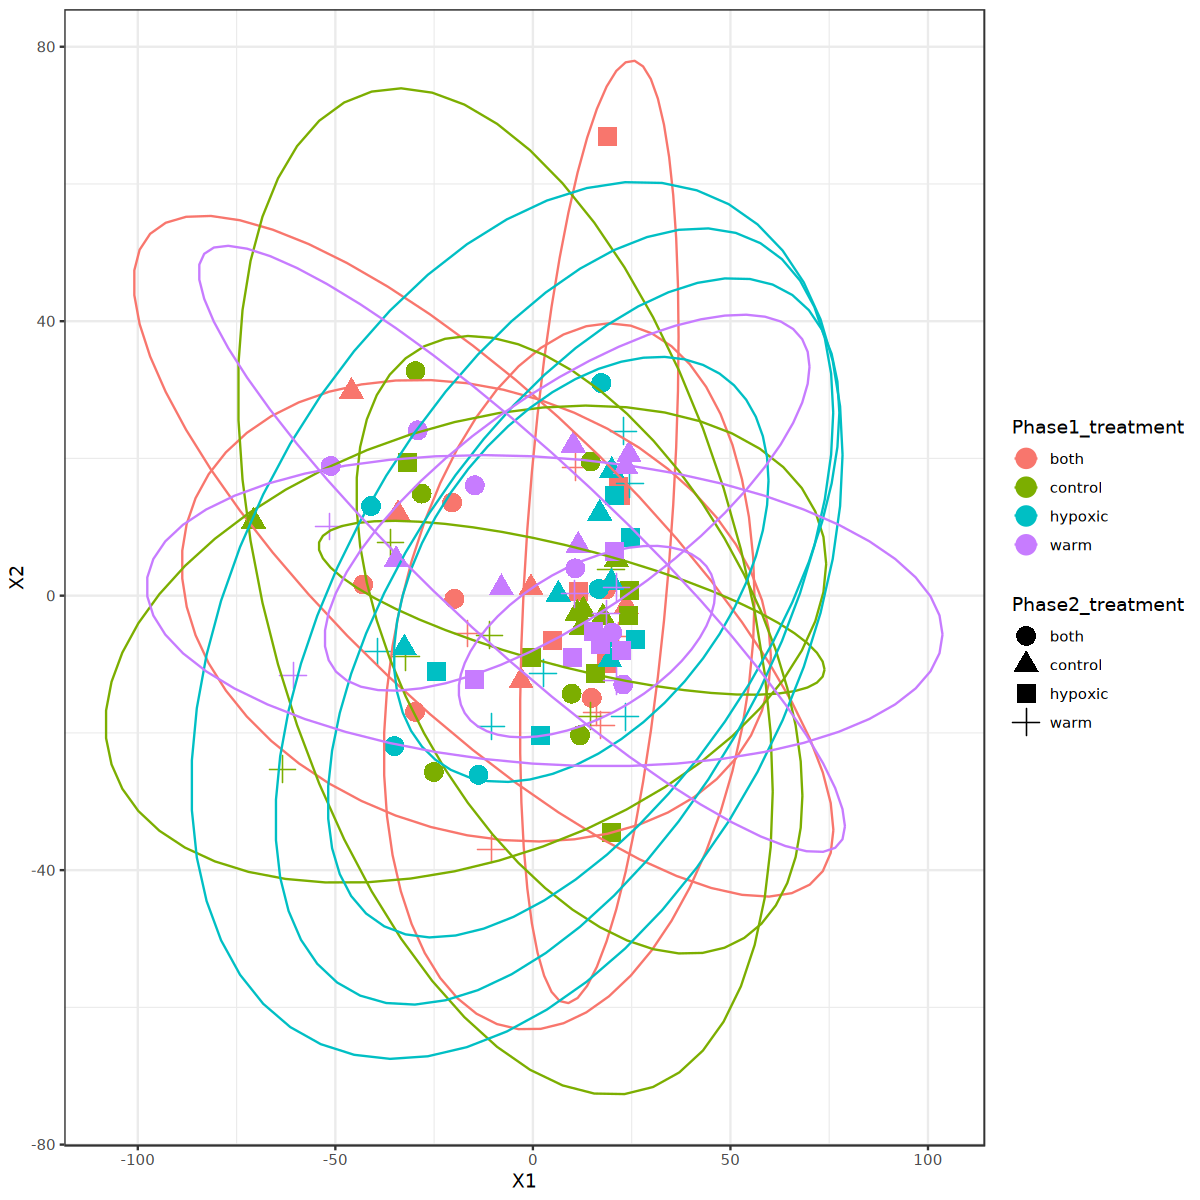

In [45]:
ggplot(mds_filtered, aes(X1, X2, col = Phase1_treatment, shape = Phase2_treatment)) +
geom_point(size = 5) +
stat_ellipse() + 
theme_bw()

okay so it appears when we remove those two seemingly outlier samples, the data gets a little bit 'more clear' and replicates segregate a little better

## Pairwise comparisons

### 1. Effect of single exposure on GE after a period of recovery
- CC vs. WC
- CC vs. HC
- CC vs. BC

**CC vs. WC**


out of 35412 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 48, 0.14%
LFC < -1.00 (down) : 59, 0.17%
outliers [1]       : 1060, 3%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat pvalue padj B1_B1_O01 
1 LOC111116054   8.9537018  0.3300359     0.7422781 0    1      1      1.866636
2 LOC111126949 558.9188428 -0.0335083     0.4001418 0    1      1    825.986574
3 LOC111110729 112.7023690  0.1375695     0.2479809 0    1      1     59.732362
4 LOC111112434   7.0206931 -0.4272187     1.0503005 0    1      1     10.266500
5 LOC111120752 427.4811709 -0.3218775     0.2852003 0    1      1    335.994538
6 LOC111128944   0.1058866  0.0000000     8.2454087 0    1      1      0.000000
  B1_W5_O50  B2_B5_O51  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46  W5_W2_G22 
1   5.925652   9.397297 ⋯   4.308183   2.436697  11.10840   1.994767   7.317628
2 471.089320 614.583255 ⋯ 229.410737 540.946738 502.34665 738.063823 646.695362
3  91.847603  59.202974 ⋯ 128.168440  61.729658  86.39869 148.610148 110.679121
4   1.975217   0.000000 ⋯   6.462274   0.000000  13.57694   5.984301   3.658814
5 331.836502 400.324872 ⋯ 418.970782 284.281319 443.10184 344.097323 400.640125
6   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000   0.000000   0.000000
  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   5.245991   2.287545  20.92789   1.068844   0.0000 
2 425.974455 478.096882 467.02232 300.345215 632.2158 
3 120.657789 144.115328 118.95851 135.743211 224.8113 
4   0.000000   2.287545  17.62348   8.550753   0.0000 
5 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.00000   0.000000   0.0000

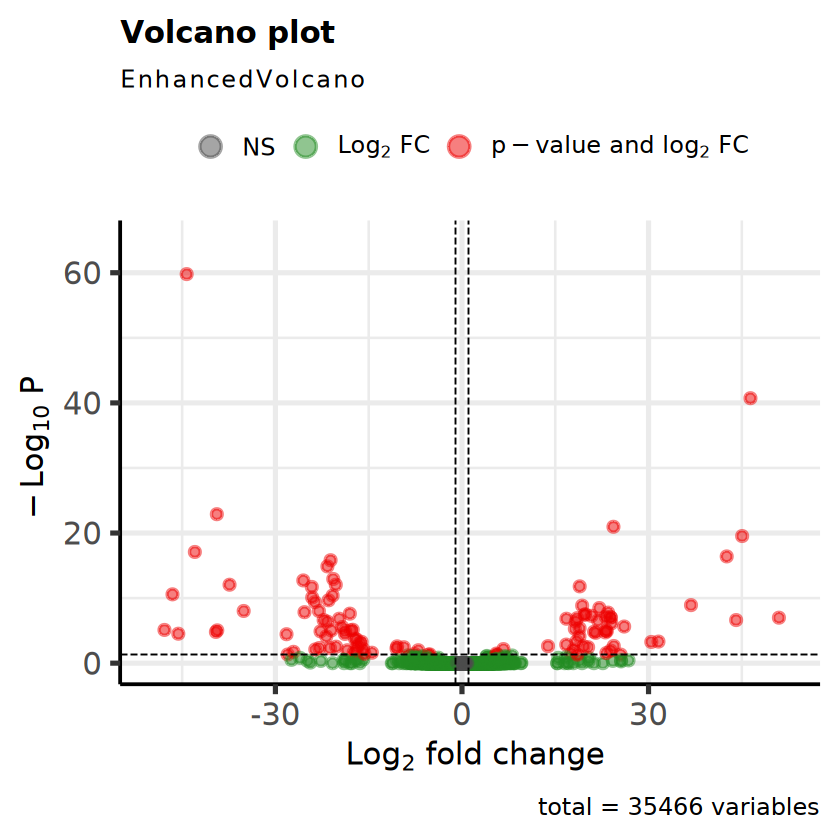

In [14]:
#res.wc.cc <- lfcShrink(dds, 
 #                      contrast= c('complete_trtmt', 'warm.control', 'control.control'), # CC is the "control"
  #                   type = 'ashr',
   #                   lfcThreshold = 1)

res.wc.cc <- results(dds, contrast = c('complete_trtmt', 'warm.control', 'control.control'), alpha = 0.05, lfcThreshold = 1)

summary(res.wc.cc)

EnhancedVolcano(res.wc.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wc.cc <- merge(res.wc.cc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wc.cc)[1] <- 'Gene'

head(res.wc.cc)

In [15]:
write.csv(res.wc.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/nolfcShrink_test/deseq_res/wc_cc.csv')

**CC vs. HC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 49, 0.14%
LFC < -1.00 (down) : 151, 0.43%



Gene         baseMean    log2FoldChange lfcSE       stat          pvalue   
1 LOC111116054   8.9537018 -8.096919e-05  0.016814251 -0.2235326976 0.8231209
2 LOC111126949 558.9188428  1.369412e-07  0.008530781  0.0007528354 0.9993993
3 LOC111110729 112.7023690  3.173216e-05  0.006828489  0.1697359848 0.8652178
4 LOC111112434   7.0206931  7.570096e-05  0.025678136  0.1209991778 0.9036917
5 LOC111120752 427.4811709 -1.577493e-04  0.008181854 -0.8108932333 0.4174270
6 LOC111128944   0.1058866  0.000000e+00  0.481206078  0.0000000000 1.0000000
  padj svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1    0.9847619   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 1    0.9882298 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 1    0.9897895  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 1    0.9831684  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 1    0.9885123 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6 1    0.9524828   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

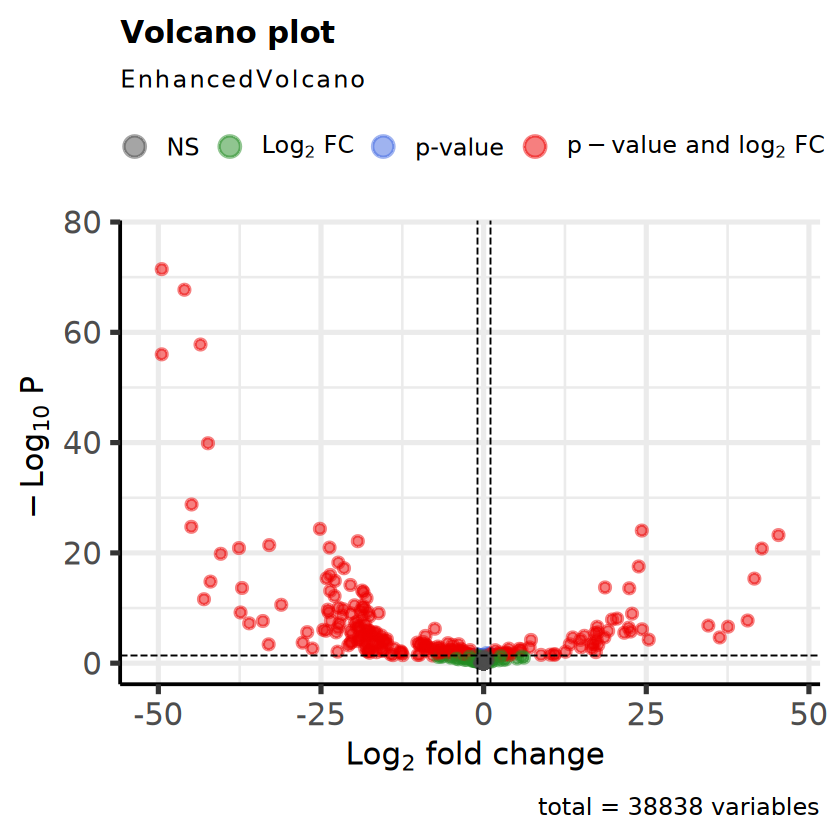

In [18]:
res.hc.cc <- lfcShrink(dds, contrast= c('complete_trtmt', 'hypoxic.control', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hc.cc)

EnhancedVolcano(res.hc.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hc.cc <- merge(res.hc.cc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hc.cc)[1] <- 'Gene'

head(res.hc.cc)

In [19]:
write.csv(res.hc.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hc_cc.csv')

**CC vs. BC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 254, 0.72%
LFC < -1.00 (down) : 42, 0.12%



Gene         baseMean    log2FoldChange lfcSE      stat        pvalue    
1 LOC111116054   8.9537018 -1.970053e-03  0.06727474 -0.36976016 0.71156121
2 LOC111126949 558.9188428  1.511372e-02  0.11862347  1.86626611 0.06200414
3 LOC111110729 112.7023690  1.709282e-05  0.01322136  0.02431629 0.98060032
4 LOC111112434   7.0206931 -1.545040e-03  0.09994074 -0.16584289 0.86828059
5 LOC111120752 427.4811709 -1.499193e-03  0.02853859 -1.05889549 0.28964738
6 LOC111128944   0.1058866  0.000000e+00  0.76694440  0.00000000 1.00000000
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1.0000000 0.9453930   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.6520152 0.9261397 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 1.0000000 0.9643558  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 1.0000000 0.9411361  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.9622773 0.9583163 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6        NA 0.8876735   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

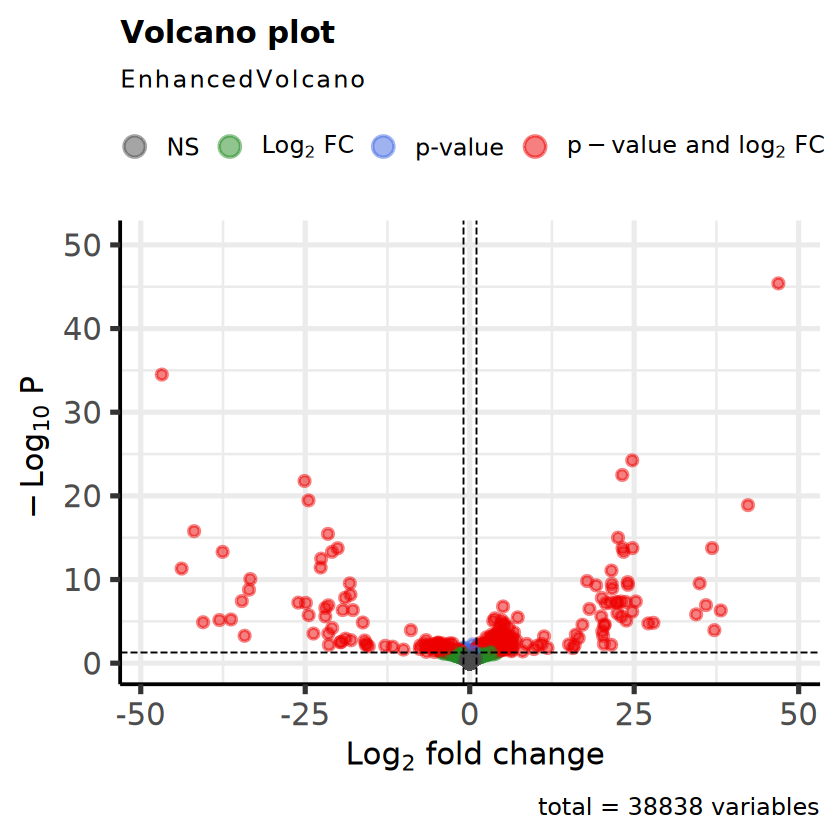

In [20]:
res.bc.cc <- lfcShrink(dds, contrast= c('complete_trtmt', 'both.control', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bc.cc)

EnhancedVolcano(res.bc.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bc.cc <- merge(res.bc.cc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bc.cc)[1] <- 'Gene'

head(res.bc.cc)

In [21]:
write.csv(res.bc.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_cc.csv')

### 2. Effect of single exposure experienced only later in life
- CC vs. CW
- CC vs. CH
- CC vs. CB

**CC vs. CW**


out of 35412 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 44, 0.12%
LFC < -1.00 (down) : 65, 0.18%
outliers [1]       : 1060, 3%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue    padj
1 LOC111116054   8.9537018 -0.2042683     0.7509216 0.00000000 1.0000000 1   
2 LOC111126949 558.9188428  0.3443224     0.3999352 0.00000000 1.0000000 1   
3 LOC111110729 112.7023690  0.5386995     0.2466049 0.00000000 1.0000000 1   
4 LOC111112434   7.0206931 -0.6712629     1.0570339 0.00000000 1.0000000 1   
5 LOC111120752 427.4811709 -0.4345494     0.2853547 0.00000000 1.0000000 1   
6 LOC111128944   0.1058866  1.1657224     8.2454087 0.02009874 0.9839646 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.866636   5.925652   9.397297 ⋯   4.308183   2.436697  11.10840   1.994767
2 825.986574 471.089320 614.583255 ⋯ 229.410737 540.946738 502.34665 738.063823
3  59.732362  91.847603  59.202974 ⋯ 128.168440  61.729658  86.39869 148.610148
4  10.266500   1.975217   0.000000 ⋯   6.462274   0.000000  13.57694   5.984301
5 335.994538 331.836502 400.324872 ⋯ 418.970782 284.281319 443.10184 344.097323
6   0.000000   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

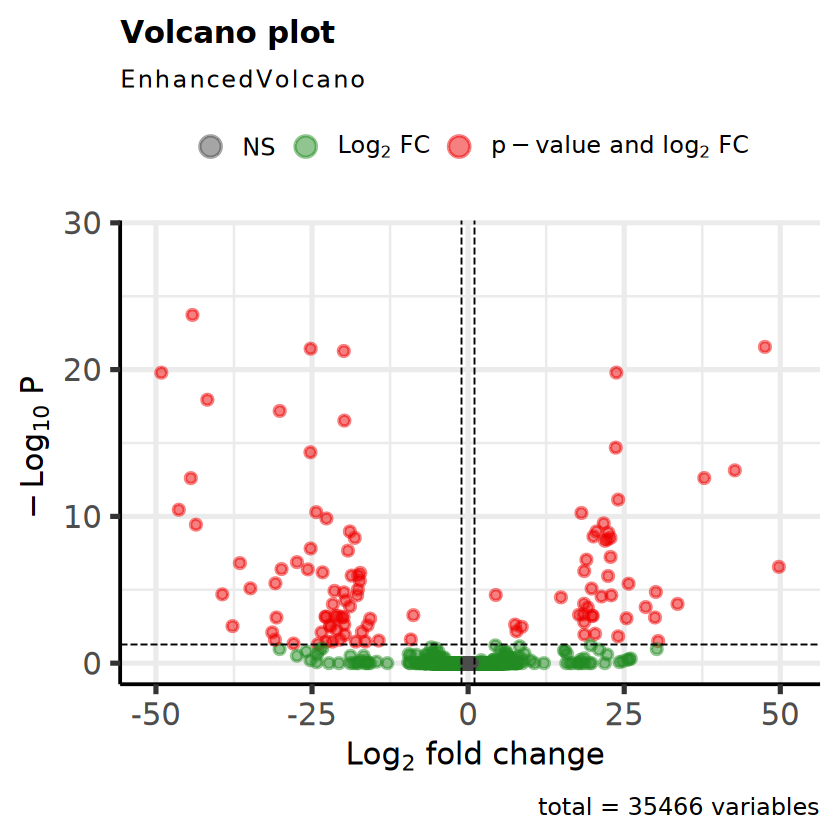

In [16]:
#res.cw.cc <- lfcShrink(dds, contrast= c('complete_trtmt', 'control.warm', 'control.control'), # CC is the "control"
 #                    type = 'ashr',
  #                    lfcThreshold = 1)

res.cw.cc <- results(dds, contrast= c('complete_trtmt', 'control.warm', 'control.control'), alpha = 0.05, lfcThreshold = 1)

summary(res.cw.cc)

EnhancedVolcano(res.cw.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cw.cc <- merge(res.cw.cc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cw.cc)[1] <- 'Gene'

head(res.cw.cc)

In [17]:
write.csv(res.cw.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/nolfcShrink_test/deseq_res/cw_cc.csv')

**CC vs. CH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 58, 0.16%
LFC < -1.00 (down) : 121, 0.34%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue    
1 LOC111116054   8.9537018 -0.014067449   0.09605896 -1.2875125 0.19791572
2 LOC111126949 558.9188428  0.015351842   0.08725780  0.8103617 0.41773234
3 LOC111110729 112.7023690  0.009349989   0.08353262  0.3320369 0.73986141
4 LOC111112434   7.0206931 -0.008073683   0.09900899 -0.9661891 0.33394956
5 LOC111120752 427.4811709 -0.060383216   0.09068394 -2.3322141 0.01968943
6 LOC111128944   0.1058866  0.003330011   0.48360584  0.1186999 0.90551313
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9419174 0.9781403   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 1.0000000 0.9877975 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 1.0000000 0.9905282  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 0.9916471 0.9780849  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.5146240 0.9821731 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6 1.0000000 0.9535949   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

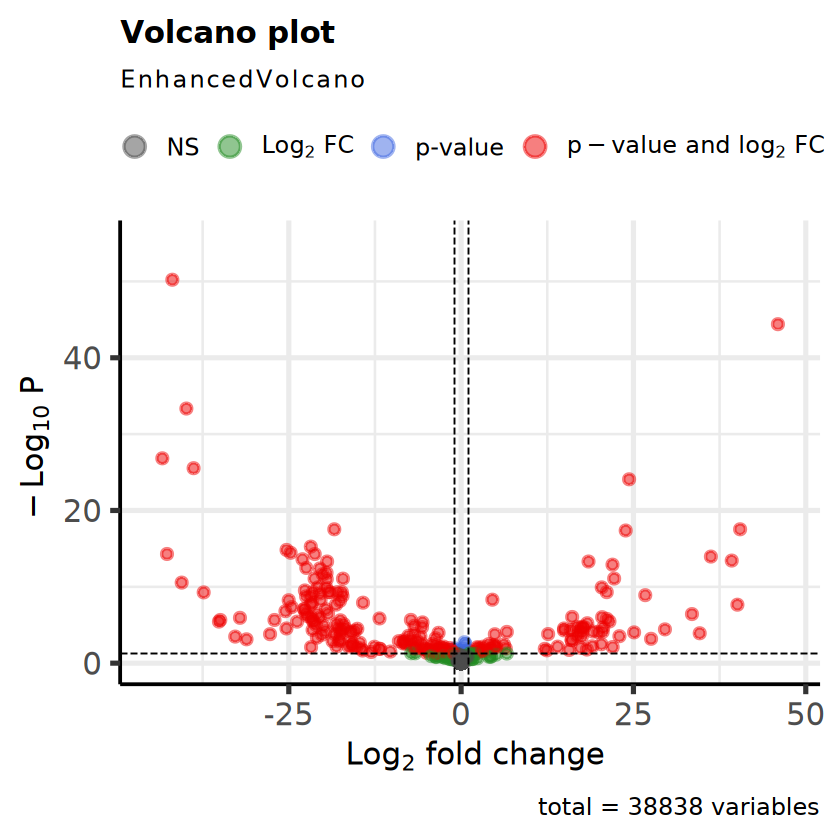

In [24]:
res.ch.cc <- lfcShrink(dds, contrast= c('complete_trtmt', 'control.hypoxic', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.ch.cc)

EnhancedVolcano(res.ch.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.ch.cc <- merge(res.ch.cc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.ch.cc)[1] <- 'Gene'

head(res.ch.cc)

In [25]:
write.csv(res.ch.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/ch_cc.csv')

**CC vs. CB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 58, 0.16%
LFC < -1.00 (down) : 139, 0.39%



Gene         baseMean    log2FoldChange lfcSE     stat        pvalue    
1 LOC111116054   8.9537018  0.0346595416  0.1568720  1.15375296 0.24860146
2 LOC111126949 558.9188428  0.0492109947  0.1393594  1.09871543 0.27189221
3 LOC111110729 112.7023690  0.0419997709  0.1196298  0.74141713 0.45844056
4 LOC111112434   7.0206931 -0.0001678805  0.1518214 -0.00759584 0.99393945
5 LOC111120752 427.4811709 -0.1189132117  0.1514006 -2.01132783 0.04429084
6 LOC111128944   0.1058866  0.0000000000  0.5070154  0.00000000 1.00000000
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9381910 0.9722096   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.9516477 0.9842334 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 1.0000000 0.9881839  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 1.0000000 0.9829513  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.5789494 0.9818877 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6 1.0000000 0.9599818   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

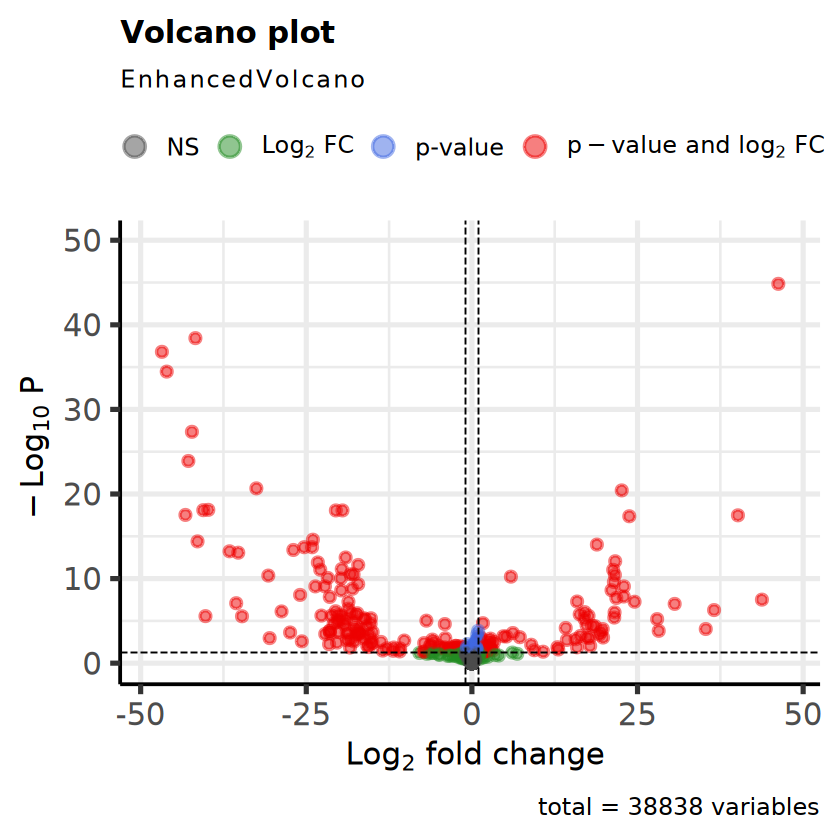

In [26]:
res.cb.cc <- lfcShrink(dds, contrast= c('complete_trtmt', 'control.both', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cb.cc)

EnhancedVolcano(res.cb.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cb.cc <- merge(res.cb.cc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cb.cc)[1] <- 'Gene'

head(res.cb.cc)

In [27]:
write.csv(res.cb.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cb_cc.csv')

### 3. Timing of Stress Exposure
How does GE change depending on when stress is experienced (when all oysters only experience stress once)?
- CH vs. HC
- CW vs. WC
- CB vs. BC

**CH vs. HC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 130, 0.37%
LFC < -1.00 (down) : 98, 0.28%



Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the EnhancedVolcano package.
  Please report the issue to the authors.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
ℹ The deprecated feature was likely used in the EnhancedVolcano package.
  Please report the issue to the authors.”


Gene         baseMean    log2FoldChange lfcSE       stat       pvalue    padj
1 LOC111116054   8.9537018 -6.552857e-04  0.031093590 -1.0633834 0.2876081 1   
2 LOC111126949 558.9188428  1.707087e-04  0.010786635  0.8094989 0.4182282 1   
3 LOC111110729 112.7023690  2.868003e-05  0.006643755  0.1618447 0.8714282 1   
4 LOC111112434   7.0206931 -1.242121e-03  0.050964950 -1.0852358 0.2778172 1   
5 LOC111120752 427.4811709 -4.059464e-04  0.013060259 -1.5210227 0.1282541 1   
6 LOC111128944   0.1058866  3.186454e-03  0.493426601  0.1089881 0.9132119 1   
  svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1 0.9773360   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840   1.994767
2 0.9857103 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665 738.063823
3 0.9891058  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869 148.610148
4 0.9714896  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694   5.984301
5 0.9858429 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184 344.097323
6 0.9457526   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

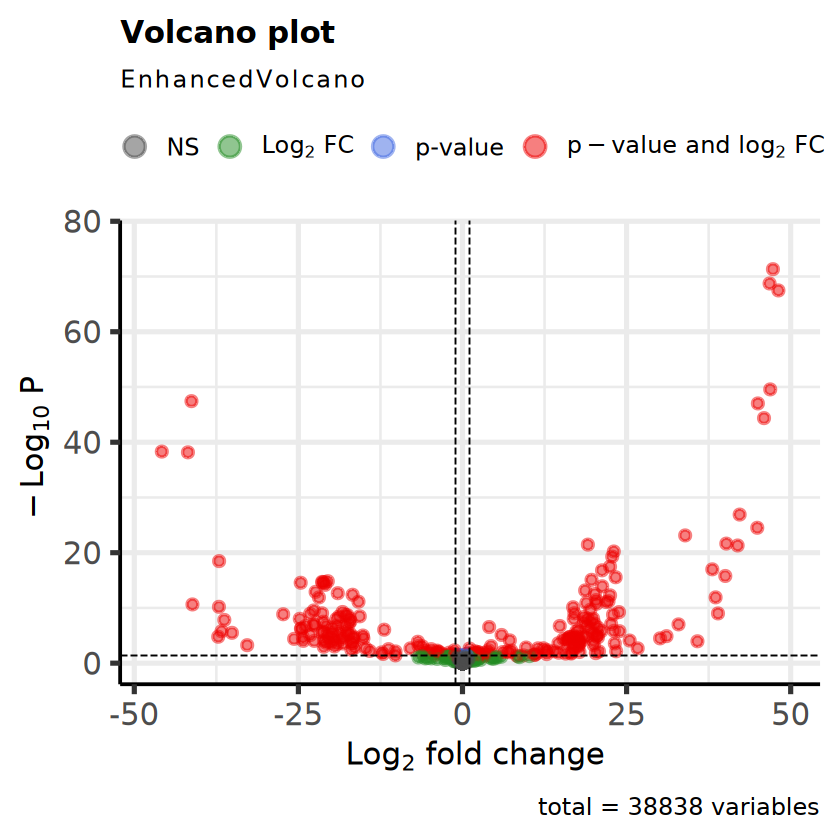

In [10]:
res.ch.hc <- lfcShrink(dds, contrast= c('complete_trtmt', 'control.hypoxic', 'hypoxic.control'), # HC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.ch.hc)

EnhancedVolcano(res.ch.hc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.ch.hc <- merge(res.ch.hc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.ch.hc)[1] <- 'Gene'

head(res.ch.hc)

In [29]:
write.csv(res.ch.hc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/ch_hc.csv')

**CW vs. WC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 76, 0.21%
LFC < -1.00 (down) : 80, 0.23%



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue   
1 LOC111116054   8.9537018 -0.026348819   0.1677944 -0.7137321 0.4753928
2 LOC111126949 558.9188428  0.056051542   0.1553088  0.9444485 0.3449405
3 LOC111110729 112.7023690  0.125537937   0.1412887  1.6262518 0.1038961
4 LOC111112434   7.0206931 -0.006329273   0.1721148 -0.2287250 0.8190826
5 LOC111120752 427.4811709 -0.028090285   0.1428640 -0.3943169 0.6933471
6 LOC111128944   0.1058866  0.003386441   0.4767069  0.1241474 0.9011986
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9378901 0.9827301   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.8828086 0.9862052 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.6573054 0.9877648  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 1.0000000 0.9828418  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.9965196 0.9889598 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6 1.0000000 0.9624499   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

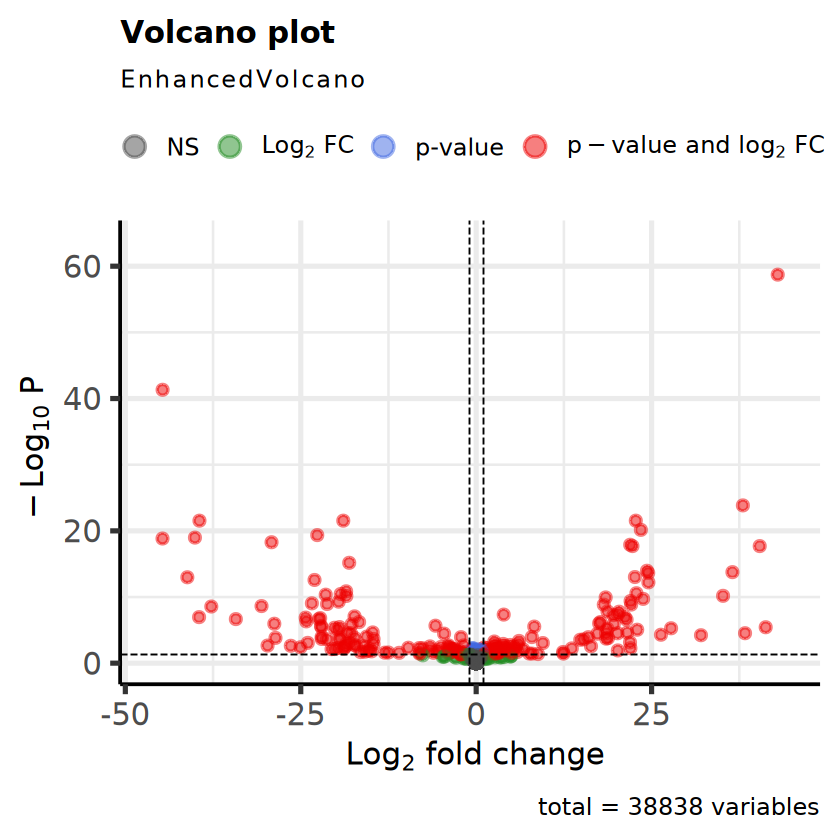

In [30]:
res.cw.wc <- lfcShrink(dds, contrast= c('complete_trtmt', 'control.warm', 'warm.control'), # WC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cw.wc)

EnhancedVolcano(res.cw.wc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cw.wc <- merge(res.cw.wc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cw.wc)[1] <- 'Gene'

head(res.cw.wc)

In [31]:
write.csv(res.cw.wc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cw_wc.csv')

**CB vs. BC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 54, 0.15%
LFC < -1.00 (down) : 508, 1.4%



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue   
1 LOC111116054   8.9537018  0.124695009   0.2916820  1.5166564 0.1293534
2 LOC111126949 558.9188428 -0.072654807   0.1992267 -0.7674397 0.4428201
3 LOC111110729 112.7023690  0.072442808   0.1611385  0.7152067 0.4744813
4 LOC111112434   7.0206931  0.009485386   0.2514351  0.1578598 0.8745673
5 LOC111120752 427.4811709 -0.097203362   0.1762645 -0.9523340 0.3409276
6 LOC111128944   0.1058866  0.000000000   0.9551525  0.0000000 1.0000000
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.5487712 0.8811976   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.8463062 0.9429978 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.8613386 0.9526558  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 0.9801243 0.9295369  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.7815035 0.9488598 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6        NA 0.8640666   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

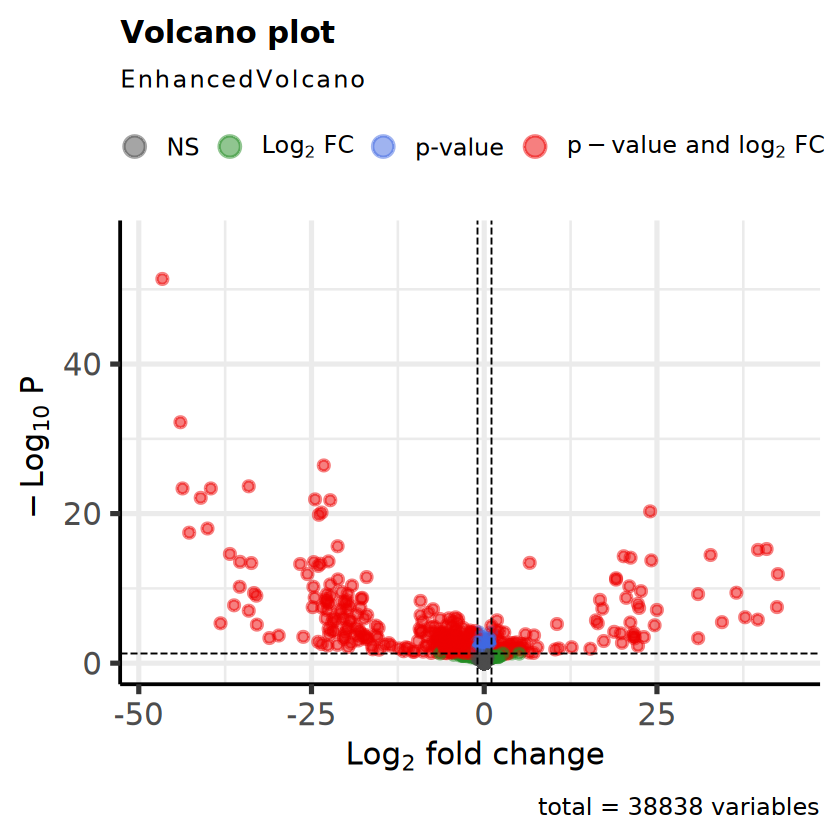

In [32]:
res.cb.bc <- lfcShrink(dds, contrast= c('complete_trtmt', 'control.both', 'both.control'), # BC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cb.bc)

EnhancedVolcano(res.cb.bc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cb.bc <- merge(res.cb.bc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cb.bc)[1] <- 'Gene'

head(res.cb.bc)

In [33]:
write.csv(res.cb.bc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cb_bc.csv')

### 4. No stress vs. most stress
- CC vs. WW
- CC vs. HH
- CC vs. BB

**CC vs. WW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 61, 0.17%
LFC < -1.00 (down) : 81, 0.23%



Gene         baseMean    log2FoldChange lfcSE       stat        pvalue    
1 LOC111116054   8.9537018 -1.694461e-03  0.053896125 -1.71050226 0.08717304
2 LOC111126949 558.9188428  1.348969e-05  0.007799016  0.08899332 0.92908722
3 LOC111110729 112.7023690  6.494117e-04  0.015815459  2.02158153 0.04321960
4 LOC111112434   7.0206931 -8.922052e-04  0.043218634 -1.11276080 0.26581118
5 LOC111120752 427.4811709 -1.790260e-04  0.008058747 -0.99842760 0.31807206
6 LOC111128944   0.1058866  4.914319e-03  0.412250383  0.25066613 0.80207225
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1.0000000 0.9738111   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 1.0000000 0.9917385 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.8868413 0.9903343  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 1.0000000 0.9805128  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 1.0000000 0.9917811 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6        NA 0.9590191   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

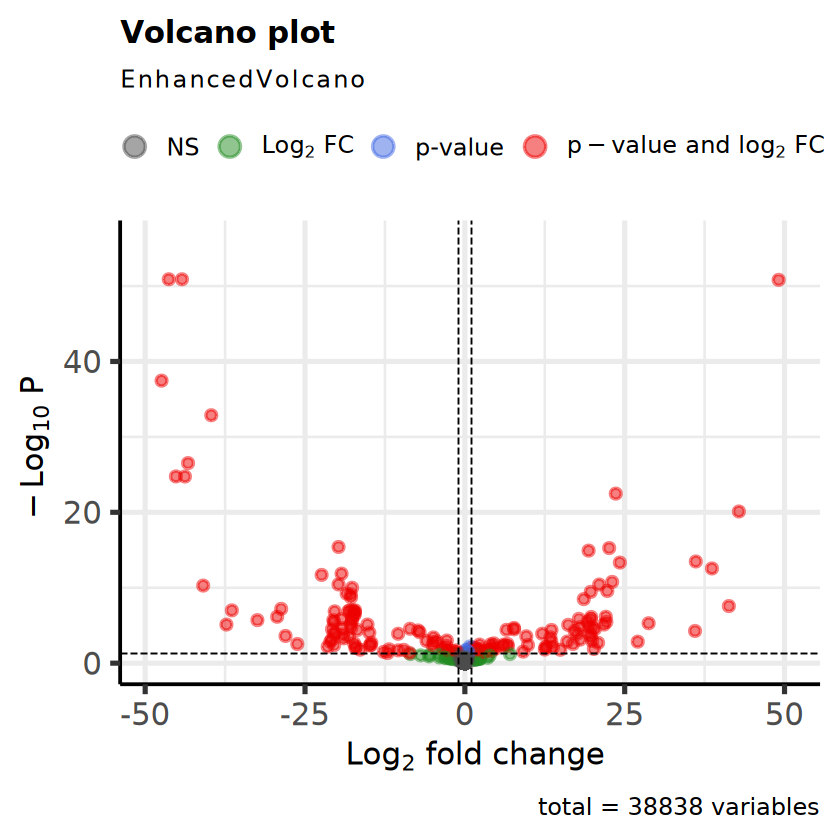

In [34]:
res.cc.ww <- lfcShrink(dds, contrast= c('complete_trtmt', 'warm.warm', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cc.ww)

EnhancedVolcano(res.cc.ww,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cc.ww <- merge(res.cc.ww, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cc.ww)[1] <- 'Gene'

head(res.cc.ww)

In [35]:
write.csv(res.cc.ww, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/ww_cc.csv')

**CC vs. HH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 387, 1.1%
LFC < -1.00 (down) : 99, 0.28%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue   
1 LOC111116054   8.9537018 -0.013467042   0.13219071 -0.8278719 0.4077430
2 LOC111126949 558.9188428  0.002660345   0.07204391  0.2065515 0.8363601
3 LOC111110729 112.7023690 -0.007234184   0.06558011 -0.4236702 0.6718064
4 LOC111112434   7.0206931 -0.004071344   0.14076522 -0.2224035 0.8239998
5 LOC111120752 427.4811709 -0.029348966   0.08879032 -1.6003166 0.1095284
6 LOC111128944   0.1058866  0.000000000   0.93314350  0.0000000 1.0000000
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9101824 0.9104003   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.9925021 0.9392758 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.9762421 0.9471161  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 0.9905886 0.9154098  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.6476511 0.9329550 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6        NA 0.8497240   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

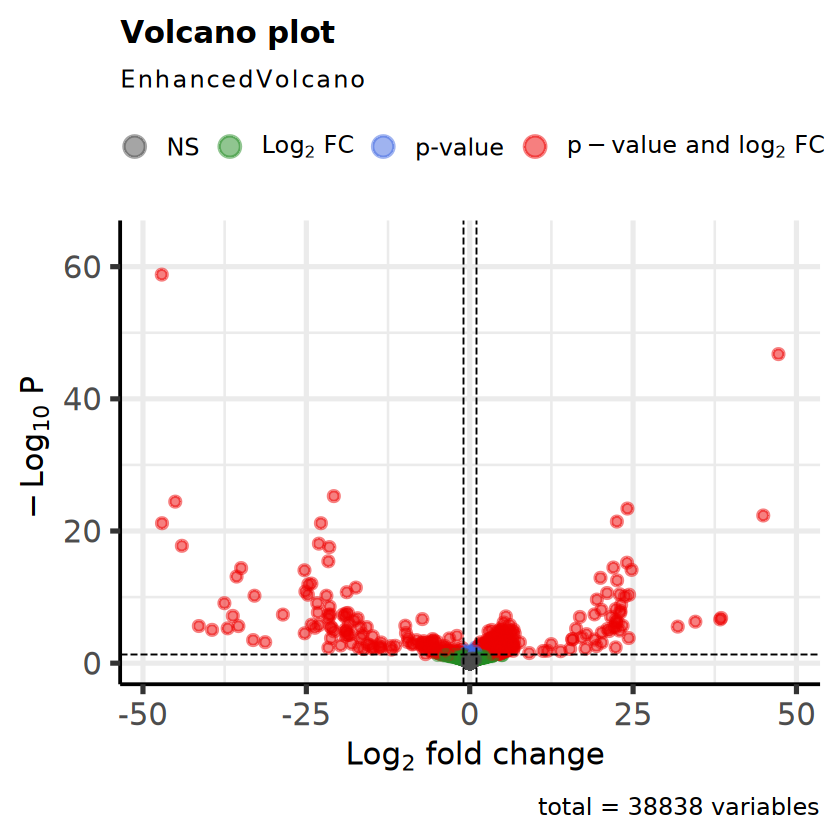

In [36]:
res.cc.hh <- lfcShrink(dds, contrast= c('complete_trtmt', 'hypoxic.hypoxic', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cc.hh)

EnhancedVolcano(res.cc.hh,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cc.hh <- merge(res.cc.hh, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cc.hh)[1] <- 'Gene'

head(res.cc.hh)

In [37]:
write.csv(res.cc.hh, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hh_cc.csv')

**CC vs. BB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 41, 0.12%
LFC < -1.00 (down) : 61, 0.17%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue    
1 LOC111116054   8.9537018  0.0202080595  0.12429017  1.2677121 0.20490079
2 LOC111126949 558.9188428 -0.0281683330  0.10245337 -1.2030773 0.22894641
3 LOC111110729 112.7023690  0.0317087955  0.09049763  1.0020605 0.31631439
4 LOC111112434   7.0206931 -0.0050885662  0.11328209 -0.4212178 0.67359602
5 LOC111120752 427.4811709  0.0732965248  0.12482504  2.1786669 0.02935642
6 LOC111128944   0.1058866 -0.0002957684  0.42423144 -0.0135484 0.98919027
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9001718 0.9717822   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.9167464 0.9874444 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.9569395 0.9906581  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 0.9983941 0.9848650  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.5662278 0.9835328 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6 0.9983941 0.9668732   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

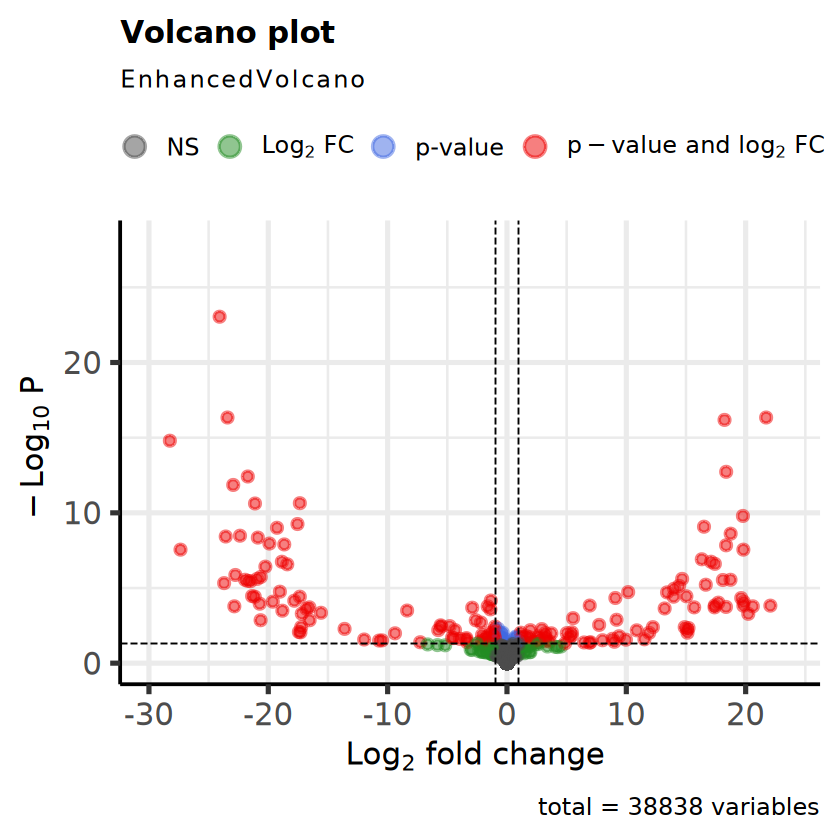

In [38]:
res.cc.bb <- lfcShrink(dds, coef='complete_trtmt_control.control_vs_both.both', # BB is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cc.bb)

EnhancedVolcano(res.cc.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cc.bb <- merge(res.cc.bb, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cc.bb)[1] <- 'Gene'

head(res.cc.bb)

switch LFC direction so CC is the baseline (deseq recognizes as bb as the baseline rn)

In [39]:
cc.bb.df <- as.data.frame(res.cc.bb) %>% # create df
mutate(log2FoldChange = log2FoldChange * -1) # multiple by -1 to make pos to neg and vice versa 

# validate
head(res.cc.bb)
head(cc.bb.df)

Gene         baseMean    log2FoldChange lfcSE      stat       pvalue    
1 LOC111116054   8.9537018  0.0202080595  0.12429017  1.2677121 0.20490079
2 LOC111126949 558.9188428 -0.0281683330  0.10245337 -1.2030773 0.22894641
3 LOC111110729 112.7023690  0.0317087955  0.09049763  1.0020605 0.31631439
4 LOC111112434   7.0206931 -0.0050885662  0.11328209 -0.4212178 0.67359602
5 LOC111120752 427.4811709  0.0732965248  0.12482504  2.1786669 0.02935642
6 LOC111128944   0.1058866 -0.0002957684  0.42423144 -0.0135484 0.98919027
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9001718 0.9717822   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.9167464 0.9874444 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.9569395 0.9906581  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 0.9983941 0.9848650  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.5662278 0.9835328 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6 0.9983941 0.9668732   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

Gene         baseMean    log2FoldChange lfcSE      stat       pvalue    
1 LOC111116054   8.9537018 -0.0202080595  0.12429017  1.2677121 0.20490079
2 LOC111126949 558.9188428  0.0281683330  0.10245337 -1.2030773 0.22894641
3 LOC111110729 112.7023690 -0.0317087955  0.09049763  1.0020605 0.31631439
4 LOC111112434   7.0206931  0.0050885662  0.11328209 -0.4212178 0.67359602
5 LOC111120752 427.4811709 -0.0732965248  0.12482504  2.1786669 0.02935642
6 LOC111128944   0.1058866  0.0002957684  0.42423144 -0.0135484 0.98919027
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9001718 0.9717822   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.9167464 0.9874444 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.9569395 0.9906581  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 0.9983941 0.9848650  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.5662278 0.9835328 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6 0.9983941 0.9668732   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

In [40]:
write.csv(cc.bb.df, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bb_cc.csv')

### 5. Effect of initial exposure on response in later exposure
(also gets at the effect of priming to stress)

#### 5A. Matched stressors
Oyster is primed with a stress, and experiences the *same* stressor again
- HH vs. CH
- WW vs. CW
- BB vs. CB

**HH vs. CH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 318, 0.9%
LFC < -1.00 (down) : 70, 0.2%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue   
1 LOC111116054   8.9537018  0.005814402   0.10840567  0.4588293 0.6463568
2 LOC111126949 558.9188428 -0.002411321   0.04638309 -0.6036898 0.5460499
3 LOC111110729 112.7023690 -0.001394425   0.02641248 -0.7548798 0.4503211
4 LOC111112434   7.0206931  0.018857479   0.20016227  0.7433600 0.4572637
5 LOC111120752 427.4811709  0.001704017   0.03159104  0.7313590 0.4645599
6 LOC111128944   0.1058866 -0.009027910   0.83861113 -0.1062792 0.9153608
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1.0000000 0.9154892   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 1.0000000 0.9319993 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.9882914 0.9425835  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 0.9899477 0.8936570  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.9911592 0.9394246 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6        NA 0.8474142   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

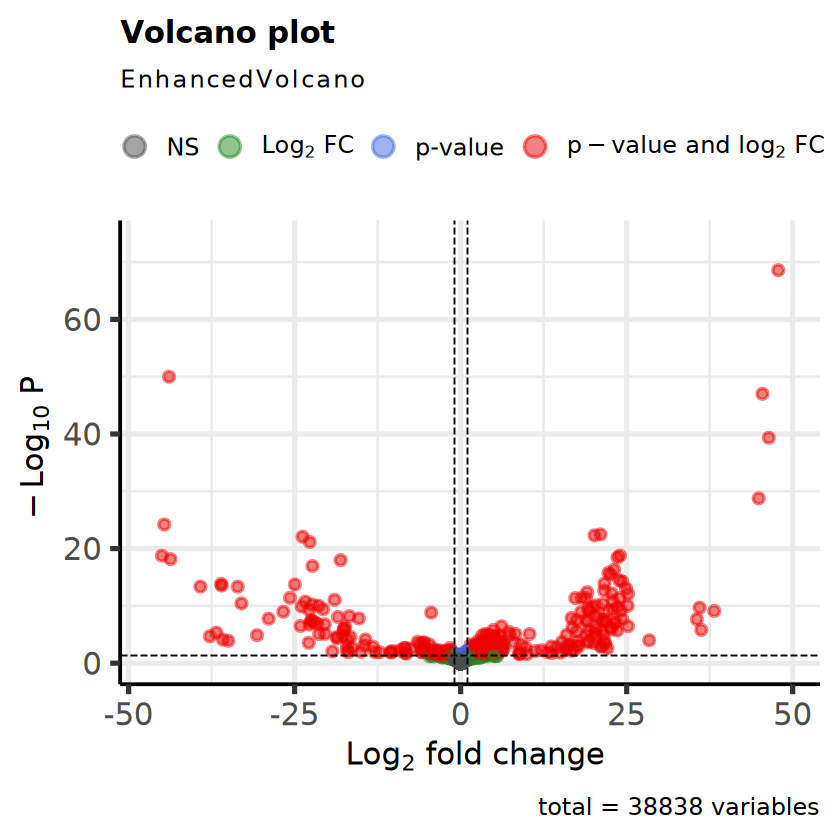

In [41]:
res.hh.ch <- lfcShrink(dds, contrast= c('complete_trtmt', 'hypoxic.hypoxic', 'control.hypoxic'), # CH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hh.ch)

EnhancedVolcano(res.hh.ch,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hh.ch <- merge(res.hh.ch, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hh.ch)[1] <- 'Gene'

head(res.hh.ch)

In [42]:
write.csv(res.hh.ch, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hh_ch.csv')

**WW vs. CW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 67, 0.19%
LFC < -1.00 (down) : 71, 0.2%



Gene         baseMean    log2FoldChange lfcSE       stat       pvalue    padj
1 LOC111116054   8.9537018 -1.012455e-03  0.040119263 -1.4362733 0.1509246 1   
2 LOC111126949 558.9188428 -1.362661e-04  0.009502915 -0.7718795 0.4401858 1   
3 LOC111110729 112.7023690 -2.929710e-05  0.006587155 -0.1660396 0.8681258 1   
4 LOC111112434   7.0206931 -2.572320e-04  0.026626438 -0.4773415 0.6331189 1   
5 LOC111120752 427.4811709  8.779066e-05  0.007114048  0.5247962 0.5997249 1   
6 LOC111128944   0.1058866  2.197359e-03  0.409290443  0.1090651 0.9131508 1   
  svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1 0.9786420   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840   1.994767
2 0.9901855 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665 738.063823
3 0.9925140  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869 148.610148
4 0.9857169  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694   5.984301
5 0.9918346 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184 344.097323
6 0.9604791   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

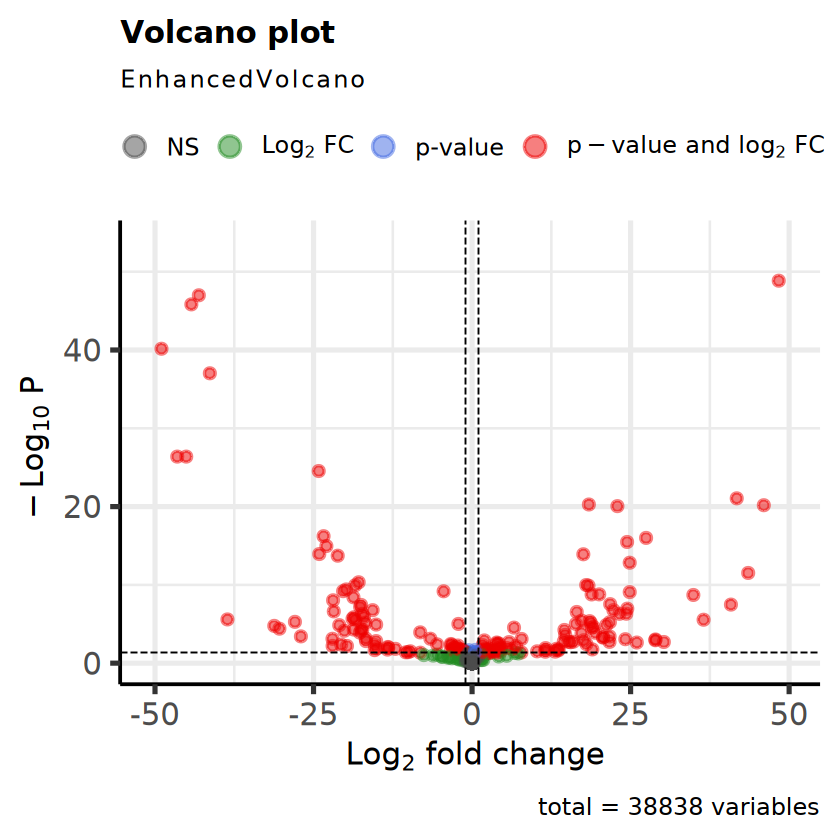

In [43]:
res.ww.cw <- lfcShrink(dds, contrast= c('complete_trtmt', 'warm.warm', 'control.warm'), # CW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.ww.cw)

EnhancedVolcano(res.ww.cw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.ww.cw <- merge(res.ww.cw, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.ww.cw)[1] <- 'Gene'

head(res.ww.cw)

In [44]:
write.csv(res.ww.cw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/ww_cw.csv')

**BB vs. CB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 42, 0.12%
LFC < -1.00 (down) : 146, 0.41%



Gene         baseMean    log2FoldChange lfcSE      stat        pvalue    
1 LOC111116054   8.9537018  1.792265e-02  0.19395878  2.40011885 0.01638975
2 LOC111126949 558.9188428 -2.602914e-05  0.01001429 -0.10426791 0.91695675
3 LOC111110729 112.7023690  7.262972e-04  0.01613291  1.73851962 0.08211930
4 LOC111112434   7.0206931 -3.907058e-04  0.03334343 -0.42774732 0.66883510
5 LOC111120752 427.4811709  4.084942e-05  0.00839841  0.16686551 0.86747588
6 LOC111128944   0.1058866  2.634282e-04  0.52367849  0.00791845 0.99368206
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.5556865 0.8647401   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.9998537 0.9864877 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.9359282 0.9853978  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 0.9998537 0.9781821  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.9998537 0.9879602 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6        NA 0.9371308   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

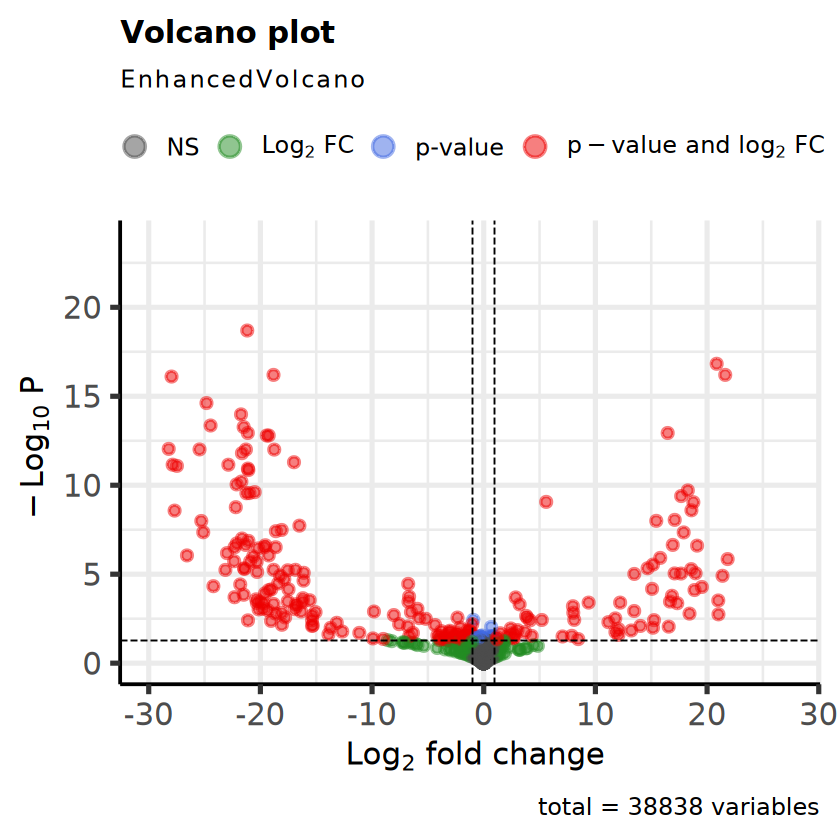

In [45]:
res.cb.bb <- lfcShrink(dds, 
                       coef= 'complete_trtmt_control.both_vs_both.both', # BB is the "control"
                       type = 'ashr',
                      lfcThreshold = 1)

summary(res.cb.bb)

EnhancedVolcano(res.cb.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cb.bb <- merge(res.cb.bb, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cb.bb)[1] <- 'Gene'

head(res.cb.bb)

In [46]:
write.csv(res.cb.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cb_bb.csv')

#### 5B. Semi-matched priming: in context of later *single* stress
- CH vs. BH
- CW vs. BW

**CH vs. BH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 107, 0.3%
LFC < -1.00 (down) : 238, 0.67%



Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the EnhancedVolcano package.
  Please report the issue to the authors.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
ℹ The deprecated feature was likely used in the EnhancedVolcano package.
  Please report the issue to the authors.”


Gene         baseMean    log2FoldChange lfcSE     stat        pvalue     
1 LOC111116054   8.9537018  0.124436558   0.2488385  1.89961581 0.057483556
2 LOC111126949 558.9188428 -0.035010970   0.1899318 -0.39145629 0.695459992
3 LOC111110729 112.7023690 -0.009030259   0.1554936 -0.09316006 0.925776402
4 LOC111112434   7.0206931  0.186252751   0.4884574  2.54327152 0.010981985
5 LOC111120752 427.4811709  0.343999618   0.2086306  2.88116464 0.003962086
6 LOC111128944   0.1058866 -0.004537529   0.6896767 -0.07900786 0.937026373
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.4184035 0.9259024   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.9499647 0.9788510 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.9974436 0.9821753  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 0.1979508 0.6305025  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.1178444 0.9468908 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6        NA 0.9286789   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

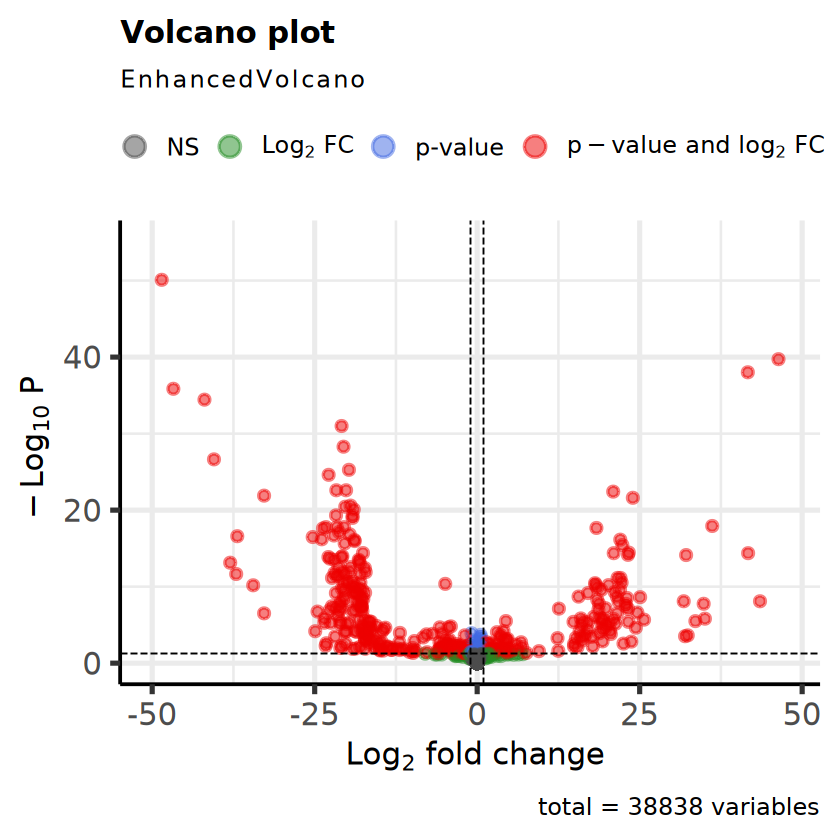

In [14]:
res.bh.ch <- lfcShrink(dds, contrast= c('complete_trtmt', 'both.hypoxic', 'control.hypoxic'), # CH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bh.ch)

EnhancedVolcano(res.bh.ch,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bh.ch <- merge(res.bh.ch, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bh.ch)[1] <- 'Gene'

head(res.bh.ch)

In [15]:
write.csv(res.bh.ch, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bh_ch.csv')

**CW vs. BW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 71, 0.2%
LFC < -1.00 (down) : 148, 0.42%



Gene         baseMean    log2FoldChange lfcSE       stat        pvalue   
1 LOC111116054   8.9537018 -8.468713e-04  0.035712630 -1.07398639 0.2828288
2 LOC111126949 558.9188428  7.431733e-06  0.008915011  0.03741552 0.9701537
3 LOC111110729 112.7023690 -6.523817e-05  0.006866093 -0.34957341 0.7266589
4 LOC111112434   7.0206931  7.129071e-04  0.039854717  0.69771813 0.4853535
5 LOC111120752 427.4811709 -3.403392e-04  0.011902089 -1.31921775 0.1870963
6 LOC111128944   0.1058866 -4.201537e-03  0.537940385 -0.12113378 0.9035851
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1.0000000 0.9761361   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 1.0000000 0.9864897 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 1.0000000 0.9881785  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 1.0000000 0.9765532  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.9613444 0.9855833 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6 1.0000000 0.9449426   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

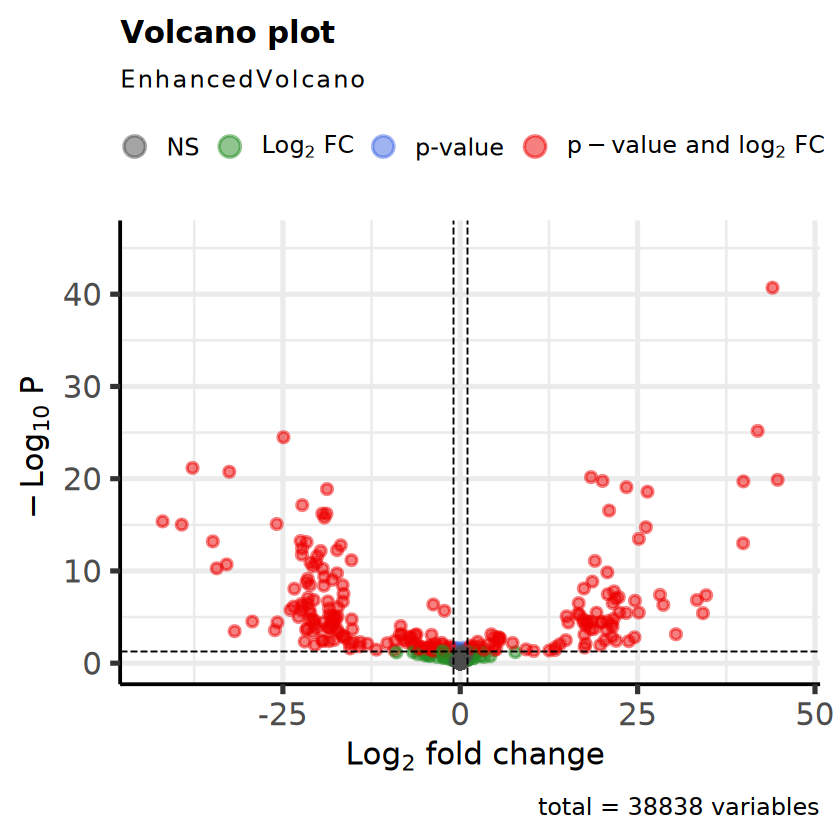

In [16]:
res.bw.cw <- lfcShrink(dds, contrast= c('complete_trtmt', 'both.warm', 'control.warm'), # CW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bw.cw)

EnhancedVolcano(res.bw.cw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bw.cw <- merge(res.bw.cw, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bw.cw)[1] <- 'Gene'

head(res.bw.cw)

In [17]:
write.csv(res.bw.cw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bw_cw.csv')

#### 5C. Semi-matched priming: in context of later *multiple* stress
- CB vs. WB
- CB vs. HB

**CB vs. WB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 174, 0.49%
LFC < -1.00 (down) : 54, 0.15%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue   
1 LOC111116054   8.9537018 -0.0071946210  0.10691957 -1.5927896 0.1112074
2 LOC111126949 558.9188428  0.0002859009  0.01635783  0.5246933 0.5997964
3 LOC111110729 112.7023690  0.0010038172  0.02142242  1.5494459 0.1212746
4 LOC111112434   7.0206931 -0.0003547978  0.05198778 -0.1401815 0.8885166
5 LOC111120752 427.4811709  0.0001932214  0.01106283  0.5381899 0.5904459
6 LOC111128944   0.1058866  0.0047147830  0.56662721  0.1224212 0.9025655
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.8423807 0.9510262   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 1.0000000 0.9798790 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.8579356 0.9806511  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 1.0000000 0.9736759  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 1.0000000 0.9822168 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6 1.0000000 0.9400733   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

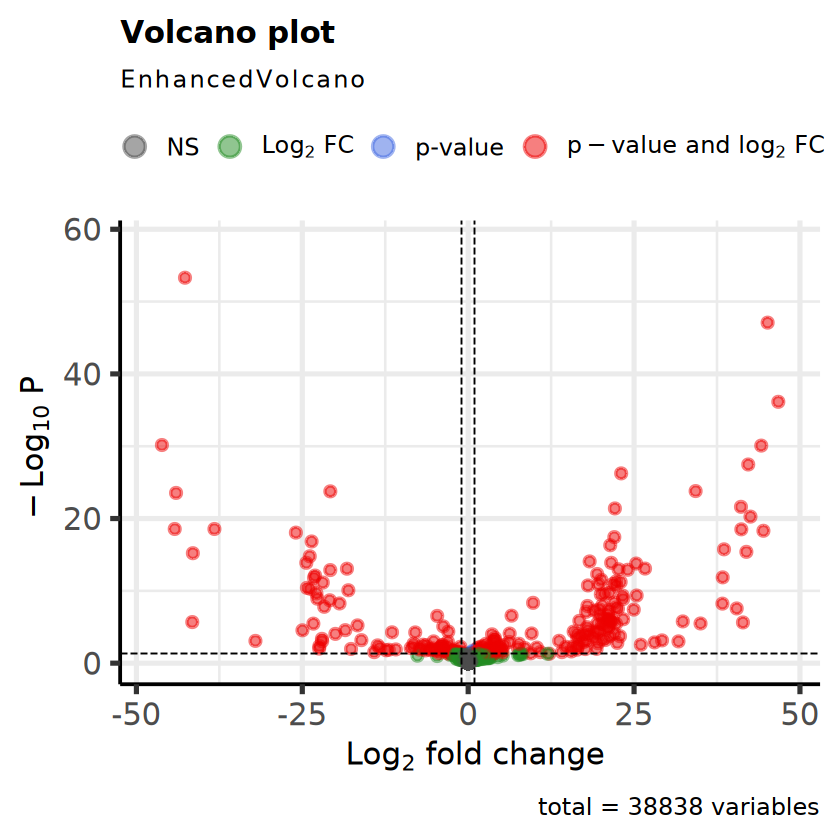

In [51]:
res.wb.cb <- lfcShrink(dds, contrast = c('complete_trtmt', 'warm.both', 'control.both'), # CB is the "control"
                       type = 'ashr',
                      lfcThreshold = 1)

summary(res.wb.cb)

EnhancedVolcano(res.wb.cb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wb.cb <- merge(res.wb.cb, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wb.cb)[1] <- 'Gene'

head(res.wb.cb)

In [52]:
write.csv(res.wb.cb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wb_cb.csv')

**CB vs. HB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 123, 0.35%
LFC < -1.00 (down) : 63, 0.18%



Gene         baseMean    log2FoldChange lfcSE       stat       pvalue    padj
1 LOC111116054   8.9537018 -3.868577e-04  0.023525561 -0.8413664 0.4001427 1   
2 LOC111126949 558.9188428  5.190832e-05  0.008662267  0.2877040 0.7735734 1   
3 LOC111110729 112.7023690 -2.645755e-04  0.008950710 -1.2187803 0.2229276 1   
4 LOC111112434   7.0206931 -3.280320e-03  0.088444902 -1.5412909 0.1232460 1   
5 LOC111120752 427.4811709  2.357629e-04  0.009447384  1.1216564 0.2620086 1   
6 LOC111128944   0.1058866  0.000000e+00  0.470634957  0.0000000 1.0000000 1   
  svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1 0.9826528   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840   1.994767
2 0.9885503 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665 738.063823
3 0.9892318  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869 148.610148
4 0.9620698  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694   5.984301
5 0.9886503 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184 344.097323
6 0.9533530   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

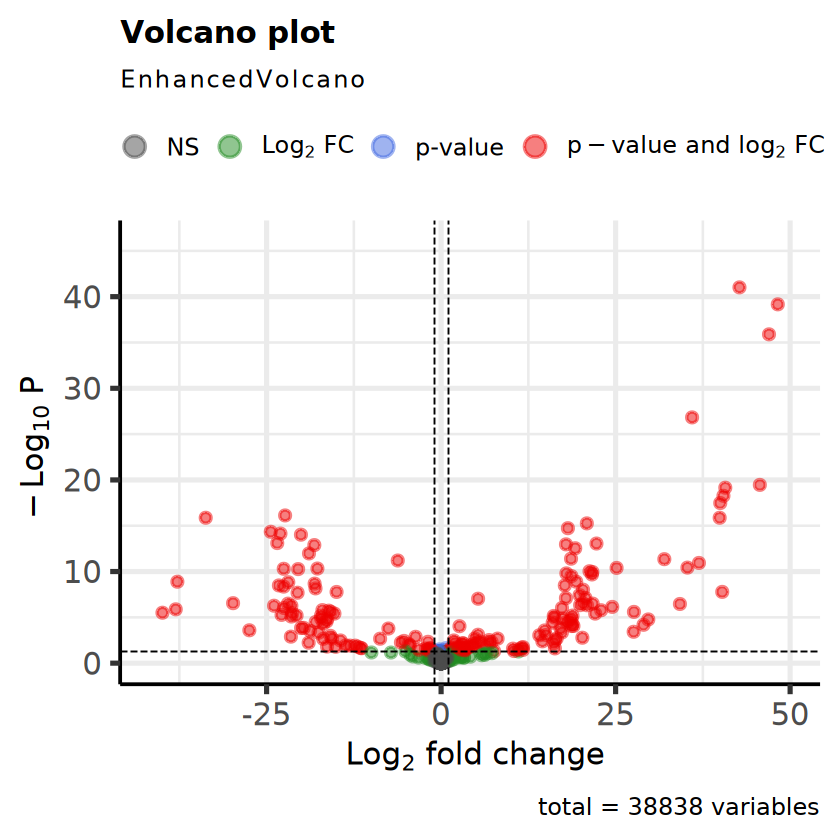

In [53]:
res.hb.cb <- lfcShrink(dds, contrast = c('complete_trtmt', 'hypoxic.both', 'control.both'), # CB is the "control"
                       type = 'ashr',
                      lfcThreshold = 1)

summary(res.hb.cb)

EnhancedVolcano(res.hb.cb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hb.cb <- merge(res.hb.cb, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hb.cb)[1] <- 'Gene'

head(res.hb.cb)

In [54]:
write.csv(res.hb.cb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hb_cb.csv')

### 6. Effect of initial exposure on subsequent response to stress
Oysters all experience the same early stressor, but either return to that stressor or experience control conditions
- HC vs. HH
- WC vs. WW
- BB vs. BC

**HC vs. HH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 96, 0.27%
LFC < -1.00 (down) : 681, 1.9%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue   
1 LOC111116054   8.9537018  0.008734854   0.11529788  0.6040960 0.5457798
2 LOC111126949 558.9188428 -0.002428385   0.06909388 -0.2057708 0.8369700
3 LOC111110729 112.7023690  0.008057564   0.06050543  0.5924087 0.5535769
4 LOC111112434   7.0206931  0.006180008   0.14280091  0.3428839 0.7316858
5 LOC111120752 427.4811709  0.010731147   0.06684057  0.7894063 0.4298746
6 LOC111128944   0.1058866  0.000000000   1.06484813  0.0000000 1.0000000
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1.0000000 0.9055605   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 1.0000000 0.9308050 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 1.0000000 0.9387317  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 1.0000000 0.9007543  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.9686026 0.9341928 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6 1.0000000 0.8212412   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

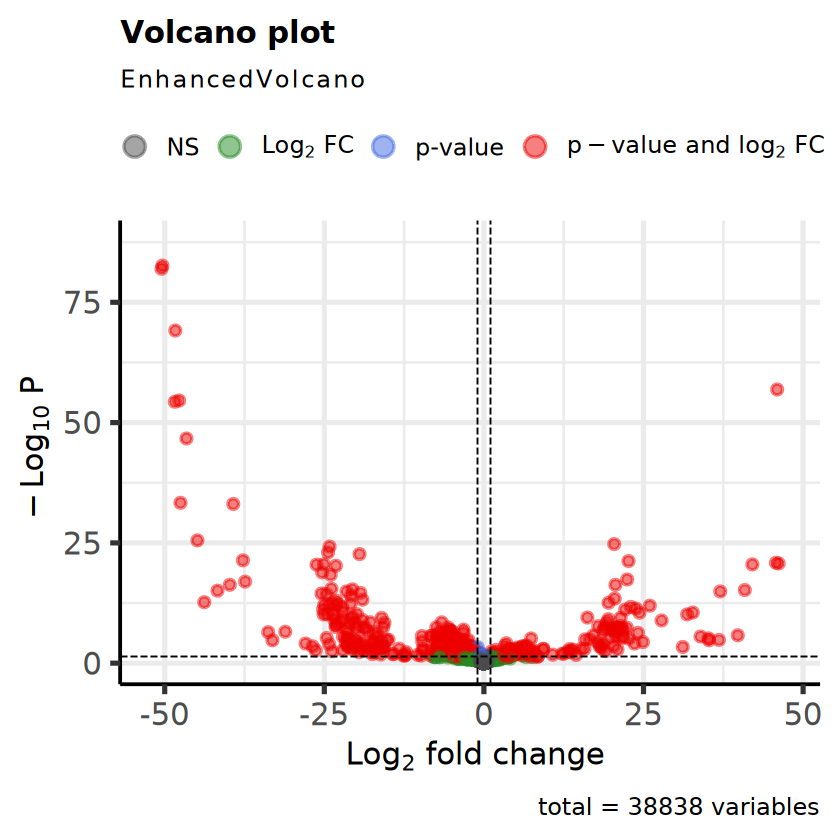

In [55]:
res.hc.hh <- lfcShrink(dds, contrast = c('complete_trtmt', 'hypoxic.control', 'hypoxic.hypoxic'), # HH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hc.hh)

EnhancedVolcano(res.hc.hh,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hc.hh <- merge(res.hc.hh, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hc.hh)[1] <- 'Gene'

head(res.hc.hh)

In [56]:
write.csv(res.hc.hh, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hc_hh.csv')

**WC vs. WW**


out of 35412 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 74, 0.21%
LFC < -1.00 (down) : 70, 0.2%
outliers [1]       : 1060, 3%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue    padj
1 LOC111116054   8.9537018  1.65836585    0.7743342  0.8502347 0.3951946 1   
2 LOC111126949 558.9188428 -0.06910985    0.4001665  0.0000000 1.0000000 1   
3 LOC111110729 112.7023690 -0.36044702    0.2464044  0.0000000 1.0000000 1   
4 LOC111112434   7.0206931  0.76201572    1.0785591  0.0000000 1.0000000 1   
5 LOC111120752 427.4811709 -0.03722888    0.2854820  0.0000000 1.0000000 1   
6 LOC111128944   0.1058866 -1.92151839    8.2324434 -0.1119374 0.9108730 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.866636   5.925652   9.397297 ⋯   4.308183   2.436697  11.10840   1.994767
2 825.986574 471.089320 614.583255 ⋯ 229.410737 540.946738 502.34665 738.063823
3  59.732362  91.847603  59.202974 ⋯ 128.168440  61.729658  86.39869 148.610148
4  10.266500   1.975217   0.000000 ⋯   6.462274   0.000000  13.57694   5.984301
5 335.994538 331.836502 400.324872 ⋯ 418.970782 284.281319 443.10184 344.097323
6   0.000000   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

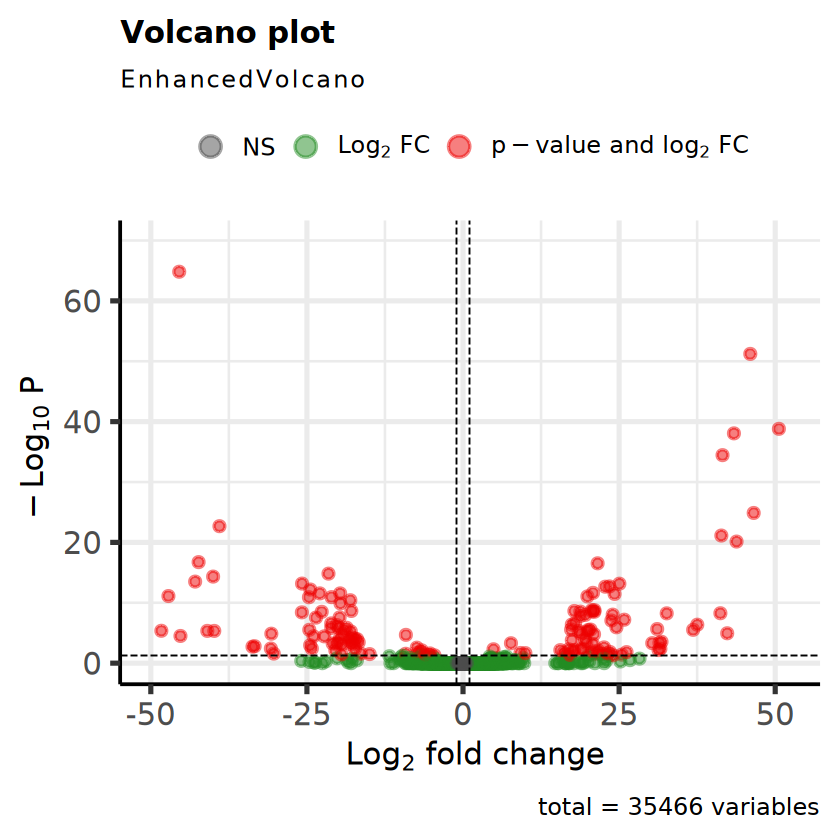

In [18]:
#res.wc.ww <- lfcShrink(dds, contrast = c('complete_trtmt', 'warm.control', 'warm.warm'), # WW is the "control"
 #                    type = 'ashr',
  #                    lfcThreshold = 1)

res.wc.ww <- results(dds, contrast = c('complete_trtmt', 'warm.control', 'warm.warm'), alpha = 0.05, lfcThreshold = 1)

summary(res.wc.ww)

EnhancedVolcano(res.wc.ww,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wc.ww <- merge(res.wc.ww, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wc.ww)[1] <- 'Gene'

head(res.wc.ww)

In [19]:
write.csv(res.wc.ww, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/nolfcShrink_test/deseq_res/wc_ww.csv')

**BC vs. BB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 159, 0.45%
LFC < -1.00 (down) : 34, 0.096%



Gene         baseMean    log2FoldChange lfcSE     stat         pvalue   
1 LOC111116054   8.9537018  0.0332748502  0.1831189  0.897572019 0.3694138
2 LOC111126949 558.9188428  0.0328168757  0.1433489  0.663227002 0.5071852
3 LOC111110729 112.7023690  0.0625961543  0.1298013  1.023691964 0.3059808
4 LOC111112434   7.0206931 -0.0194953838  0.1956861 -0.585644870 0.5581142
5 LOC111120752 427.4811709  0.0664117563  0.1378484  1.119415007 0.2629631
6 LOC111128944   0.1058866  0.0001191954  0.7065575  0.001968121 0.9984297
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.8747485 0.9399850   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.9237705 0.9593168 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.8412612 0.9651096  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 0.9398220 0.9389012  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.8108627 0.9622544 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6        NA 0.8877020   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

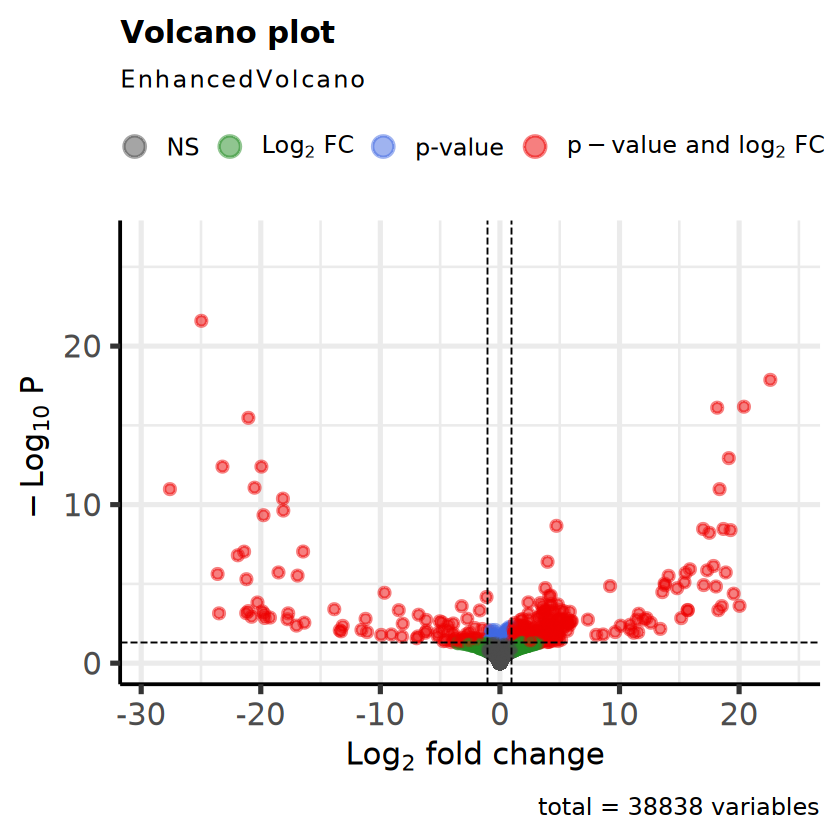

In [59]:
res.bc.bb <- lfcShrink(dds, coef = 'complete_trtmt_both.control_vs_both.both', # BB is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bc.bb)

EnhancedVolcano(res.bc.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bc.bb <- merge(res.bc.bb, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bc.bb)[1] <- 'Gene'

head(res.bc.bb)

In [60]:
write.csv(res.bc.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_bb.csv')

### 7. Effect of initial single/multiple stress on response in ...
Is it better to be primed with a single stressor or multiple stressor, depending on the context of the future enviornment (single/multiple stressor)?

#### 7A. ...later *single* stress
Oyster is primed with either multiple or a single stressors, and then experiences only a sinlge stressor later
- BH vs. HH
- BW vs. WW

**BH vs. HH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 80, 0.23%
LFC < -1.00 (down) : 759, 2.1%



Gene         baseMean    log2FoldChange lfcSE     stat      pvalue    
1 LOC111116054   8.9537018 0.11730633     0.2887787 1.4445440 0.14858600
2 LOC111126949 558.9188428 0.02102528     0.1994441 0.2119145 0.83217373
3 LOC111110729 112.7023690 0.07224022     0.1674492 0.6565209 0.51148902
4 LOC111112434   7.0206931 0.17898139     0.4930658 1.8157329 0.06941136
5 LOC111120752 427.4811709 0.25394101     0.1992376 2.1499961 0.03155552
6 LOC111128944   0.1058866 0.00000000     1.1139768 0.0000000 1.00000000
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.5309546 0.8618980   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.9667955 0.9316831 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.8424806 0.9386451  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 0.3762814 0.6132054  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.2531476 0.9129744 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6        NA 0.8233809   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

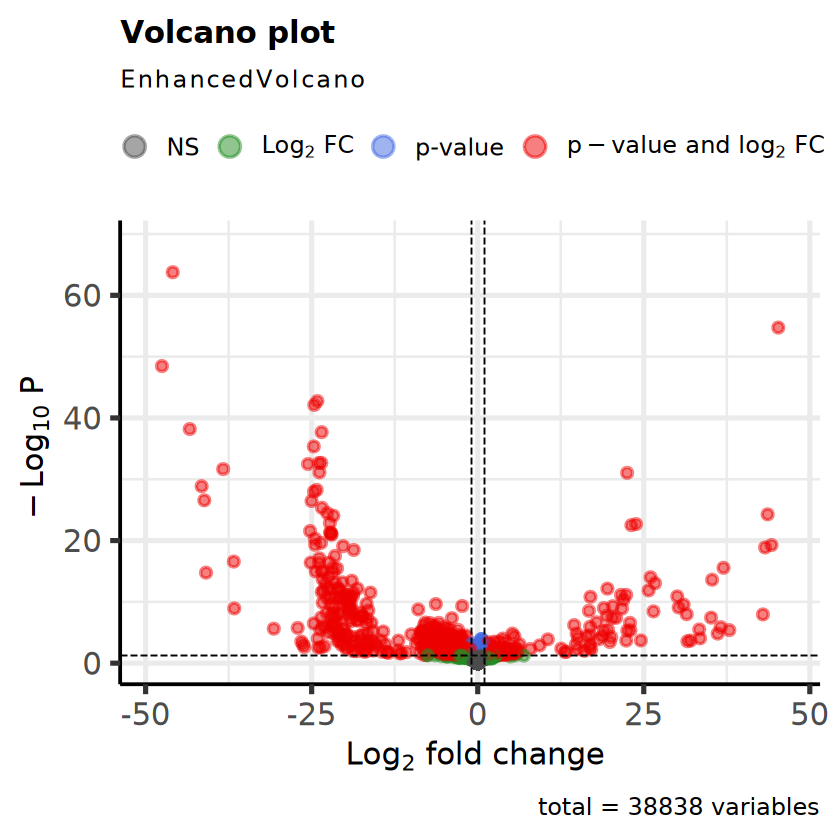

In [61]:
res.hh.bh <- lfcShrink(dds, contrast= c('complete_trtmt', 'both.hypoxic', 'hypoxic.hypoxic'), # HH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hh.bh)

EnhancedVolcano(res.hh.bh,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hh.bh <- merge(res.hh.bh, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hh.bh)[1] <- 'Gene'

head(res.hh.bh)

In [62]:
write.csv(res.hh.bh, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bh_hh.csv')

**BW vs. WW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 75, 0.21%
LFC < -1.00 (down) : 151, 0.43%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue    
1 LOC111116054   8.9537018  0.001497510   0.05790541  0.3629629 0.71663259
2 LOC111126949 558.9188428  0.005961986   0.05466629  0.8093372 0.41832124
3 LOC111110729 112.7023690 -0.002099450   0.05289802 -0.1840158 0.85400107
4 LOC111112434   7.0206931  0.005034422   0.08273647  1.1741819 0.24032218
5 LOC111120752 427.4811709 -0.018873949   0.05683463 -1.8444497 0.06511763
6 LOC111128944   0.1058866 -0.008149558   0.55107922 -0.2303897 0.81778899
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1.0000000 0.9815825   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 1.0000000 0.9846671 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 1.0000000 0.9882507  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 0.9744159 0.9684650  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.7578122 0.9832338 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6 1.0000000 0.9402526   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

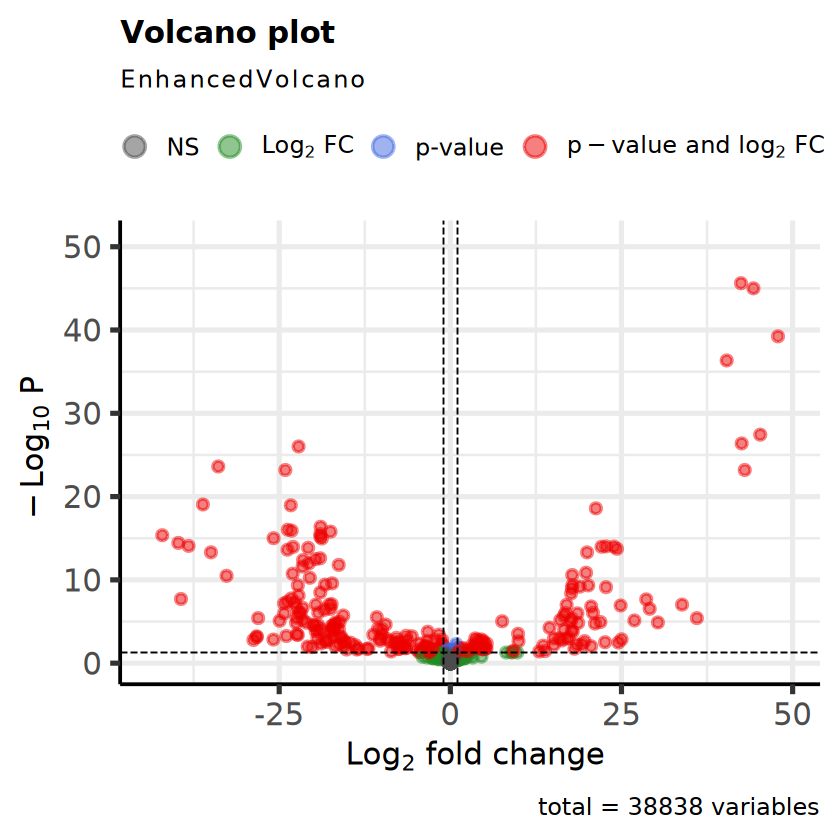

In [63]:
res.bw.ww <- lfcShrink(dds, contrast= c('complete_trtmt', 'both.warm', 'warm.warm'), # WW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bw.ww)

EnhancedVolcano(res.bw.ww,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bw.ww <- merge(res.bw.ww, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bw.ww)[1] <- 'Gene'

head(res.bw.ww)

In [64]:
write.csv(res.bw.ww, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bw_ww.csv')

#### 7B. ...later *multiple* stressors
Oyster is primed with either multiple or a single stressors, and then experiences multiple stressors later
- HB vs. BB
- WB vs. BB

**HB vs. BB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 51, 0.14%
LFC < -1.00 (down) : 92, 0.26%



Gene         baseMean    log2FoldChange lfcSE       stat        pvalue    
1 LOC111116054   8.9537018  1.936615e-03  0.056091505  1.56312398 0.11802344
2 LOC111126949 558.9188428  4.026822e-05  0.009434798  0.18347923 0.85442201
3 LOC111110729 112.7023690  1.220846e-04  0.007931304  0.51206275 0.60860709
4 LOC111112434   7.0206931 -9.310912e-03  0.157627333 -1.95470085 0.05061839
5 LOC111120752 427.4811709  3.650604e-04  0.011559506  1.28866045 0.19751616
6 LOC111128944   0.1058866  7.016942e-04  0.464801177  0.02678759 0.97862915
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9998385 0.9687096   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.9998385 0.9893699 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.9998385 0.9907552  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 0.8209396 0.9123866  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.9998385 0.9889090 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6        NA 0.9501781   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

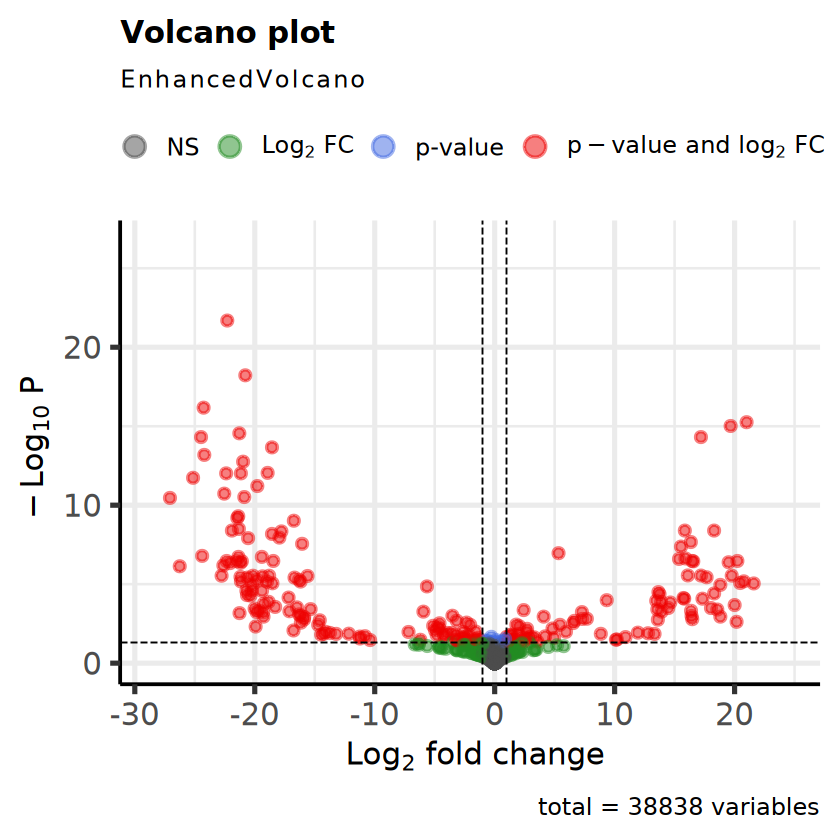

In [65]:
res.hb.bb <- lfcShrink(dds, 
                       coef= 'complete_trtmt_hypoxic.both_vs_both.both', # BB is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hb.bb)

EnhancedVolcano(res.hb.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hb.bb <- merge(res.hb.bb, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hb.bb)[1] <- 'Gene'

head(res.hb.bb)

In [66]:
write.csv(res.hb.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hb_bb.csv')

**WB vs. BB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 39, 0.11%
LFC < -1.00 (down) : 46, 0.13%



Gene         baseMean    log2FoldChange lfcSE       stat       pvalue     
1 LOC111116054   8.9537018  0.0004689725  0.026464183  0.8156623 0.414693293
2 LOC111126949 558.9188428  0.0001012206  0.010193506  0.4204707 0.674141607
3 LOC111110729 112.7023690  0.0276040918  0.152427191  3.2851418 0.001019311
4 LOC111112434   7.0206931 -0.0004530096  0.032734631 -0.5673688 0.570463675
5 LOC111120752 427.4811709  0.0001755812  0.008980415  0.7051371 0.480724944
6 LOC111128944   0.1058866  0.0024705723  0.397720494  0.1303750 0.896269770
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9998261 0.9879421   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.9998261 0.9919779 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.1357184 0.9089459  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 0.9998261 0.9873418  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.9998261 0.9927255 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6 0.9998261 0.9582476   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

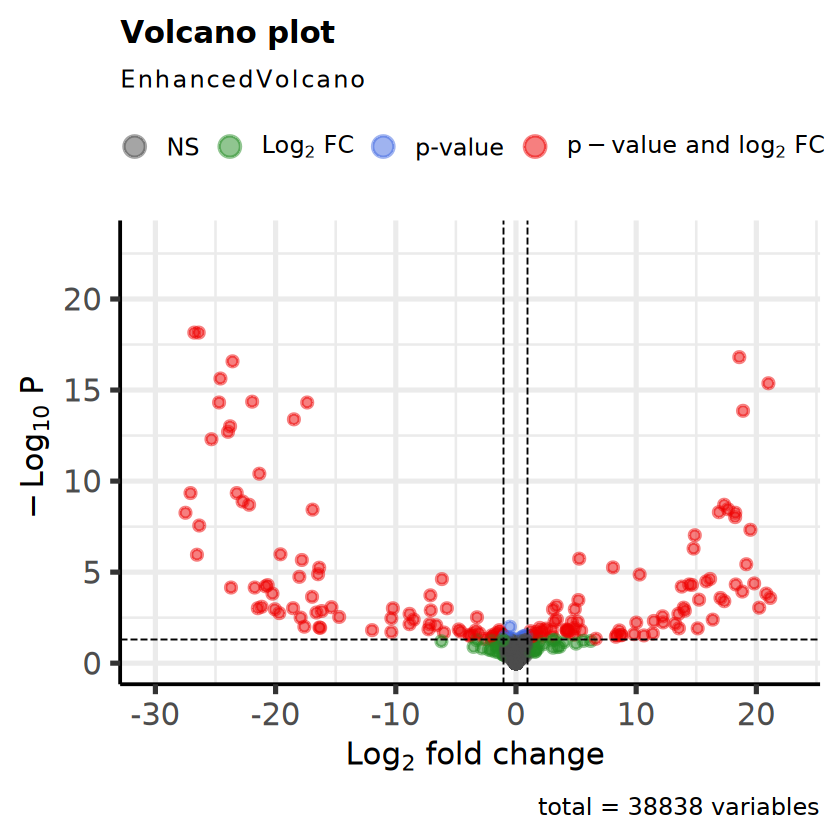

In [67]:
res.wb.bb <- lfcShrink(dds, 
                       coef= 'complete_trtmt_warm.both_vs_both.both', # BB is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.wb.bb)

EnhancedVolcano(res.wb.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wb.bb <- merge(res.wb.bb, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wb.bb)[1] <- 'Gene'

head(res.wb.bb)

In [68]:
write.csv(res.wb.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wb_bb.csv')

### 8. Shared/Unique responses among stressors with ...

#### 8A. ...different *early* stressors
>can compare these with the phase 1 vs. phase 1 DEGs to see if there are similarities
- WC vs. HC: single early stress
- BC vs. HC: mulitple vs. single
- BC vs. WC: multiple vs. single

**WC vs. HC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 144, 0.41%
LFC < -1.00 (down) : 70, 0.2%



Gene         baseMean    log2FoldChange lfcSE       stat        pvalue   
1 LOC111116054   8.9537018  2.994524e-04  0.021621729  0.66657999 0.5050405
2 LOC111126949 558.9188428 -1.557895e-05  0.008605965 -0.08448235 0.9326729
3 LOC111110729 112.7023690  7.156798e-05  0.006897891  0.38463075 0.7005110
4 LOC111112434   7.0206931 -4.012430e-04  0.031787137 -0.52680600 0.5983283
5 LOC111120752 427.4811709 -5.656515e-05  0.007226719 -0.31783413 0.7506108
6 LOC111128944   0.1058866  0.000000e+00  0.496557007  0.00000000 1.0000000
  padj svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1  1   0.9815026   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2  1   0.9870856 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3  1   0.9887725  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4  1   0.9792090  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5  1   0.9882887 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6 NA   0.9500157   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

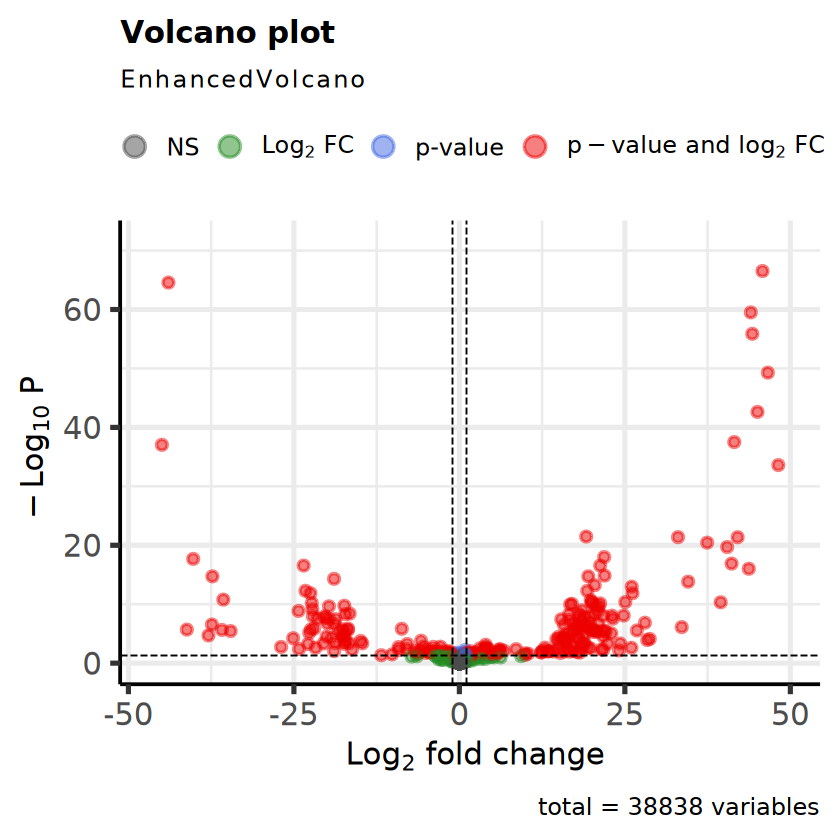

In [69]:
res.wc.hc <- lfcShrink(dds, contrast=c('complete_trtmt', 'warm.control', 'hypoxic.control'), # HC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.wc.hc)

EnhancedVolcano(res.wc.hc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wc.hc <- merge(res.wc.hc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wc.hc)[1] <- 'Gene'

head(res.wc.hc)

In [70]:
write.csv(res.wc.hc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wc_hc.csv')

**BC vs. HC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 554, 1.6%
LFC < -1.00 (down) : 41, 0.12%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue    
1 LOC111116054   8.9537018 -0.0008361556  0.06634972 -0.1463675 0.88363128
2 LOC111126949 558.9188428  0.0168724777  0.12528495  1.8652602 0.06214494
3 LOC111110729 112.7023690 -0.0001133596  0.01406400 -0.1450070 0.88470533
4 LOC111112434   7.0206931 -0.0030790535  0.10998441 -0.2863363 0.77462054
5 LOC111120752 427.4811709 -0.0002437837  0.01718799 -0.2481325 0.80403193
6 LOC111128944   0.1058866  0.0000000000  0.93194348  0.0000000 1.00000000
  padj     svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1.000000 0.9311903   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.626674 0.9040179 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 1.000000 0.9527165  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 1.000000 0.9199485  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 1.000000 0.9502864 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6       NA 0.8537713   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

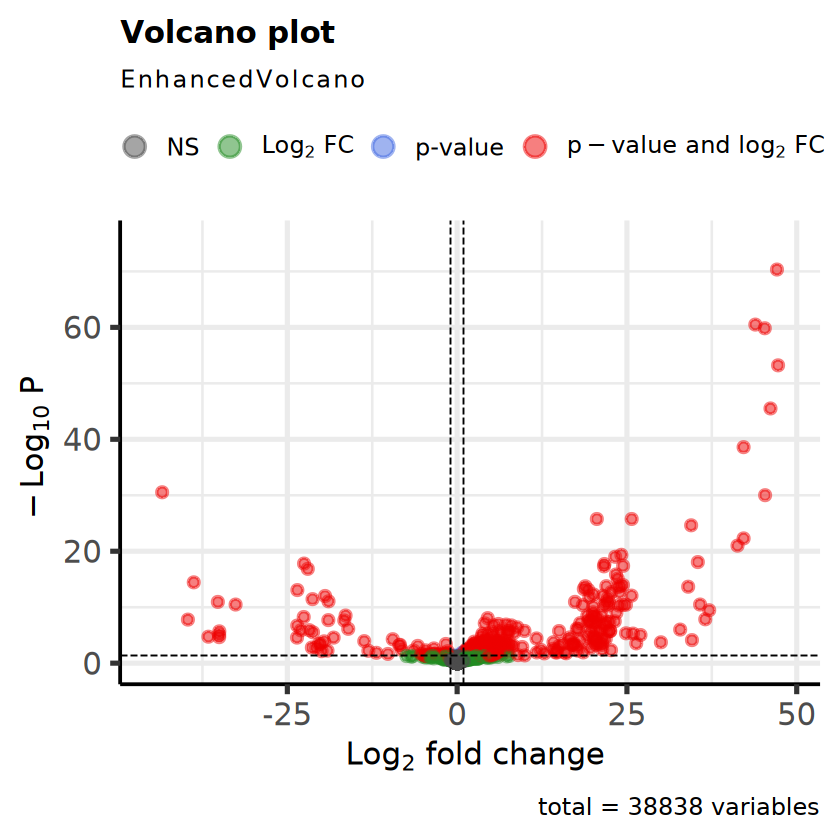

In [71]:
res.bc.hc <- lfcShrink(dds, contrast=c('complete_trtmt', 'both.control', 'hypoxic.control'), # HC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bc.hc)

EnhancedVolcano(res.bc.hc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bc.hc <- merge(res.bc.hc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bc.hc)[1] <- 'Gene'

head(res.bc.hc)

In [72]:
write.csv(res.bc.hc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_hc.csv')

**BC vs. WC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 178, 0.5%
LFC < -1.00 (down) : 43, 0.12%



Gene         baseMean    log2FoldChange lfcSE      stat        pvalue    
1 LOC111116054   8.9537018 -0.0080149869  0.10883198 -0.81151229 0.41707154
2 LOC111126949 558.9188428  0.0272085440  0.15847736  1.94951255 0.05123425
3 LOC111110729 112.7023690 -0.0008456203  0.02159522 -0.52903606 0.59678044
4 LOC111112434   7.0206931  0.0032461418  0.12233154  0.24054002 0.80991164
5 LOC111120752 427.4811709  0.0001162343  0.02185975  0.06968926 0.94444099
6 LOC111128944   0.1058866  0.0000000000  0.67399166  0.00000000 1.00000000
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9248411 0.9379578   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.5383087 0.9212291 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.9660990 0.9625404  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 0.9880226 0.9402546  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.9988931 0.9623613 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6        NA 0.9012103   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

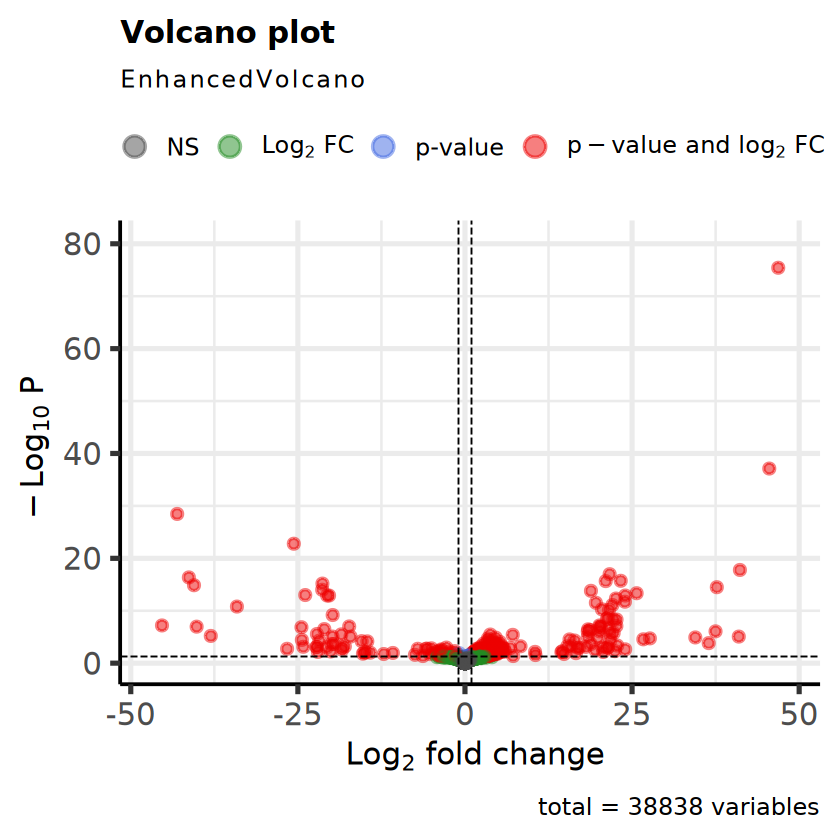

In [73]:
res.bc.wc <- lfcShrink(dds, contrast=c('complete_trtmt', 'both.control', 'warm.control'), # WC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bc.wc)

EnhancedVolcano(res.bc.wc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bc.wc <- merge(res.bc.wc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bc.wc)[1] <- 'Gene'

head(res.bc.wc)

In [74]:
write.csv(res.bc.wc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_wc.csv')

#### 8B. ...different *late* stressors
- CW vs. CH: single early stress
- CB vs. CH: mulitple vs. single
- CB vs. CW: multiple vs. single

**CW vs. CH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 127, 0.36%
LFC < -1.00 (down) : 73, 0.21%



Gene         baseMean    log2FoldChange lfcSE      stat      pvalue    
1 LOC111116054   8.9537018 1.625588e-03   0.04756008 1.0120078 0.31153433
2 LOC111126949 558.9188428 2.921953e-05   0.01517949 0.0507669 0.95951127
3 LOC111110729 112.7023690 2.218978e-03   0.03119941 1.8532347 0.06384872
4 LOC111112434   7.0206931 5.837262e-04   0.04562618 0.3288016 0.74230562
5 LOC111120752 427.4811709 4.568599e-04   0.01474226 0.8081658 0.41899513
6 LOC111128944   0.1058866 7.432732e-04   0.51980198 0.0226896 0.98189787
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1.0000000 0.9761378   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 1.0000000 0.9859699 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.7381489 0.9844798  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 1.0000000 0.9788651  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 1.0000000 0.9863602 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6 1.0000000 0.9547136   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

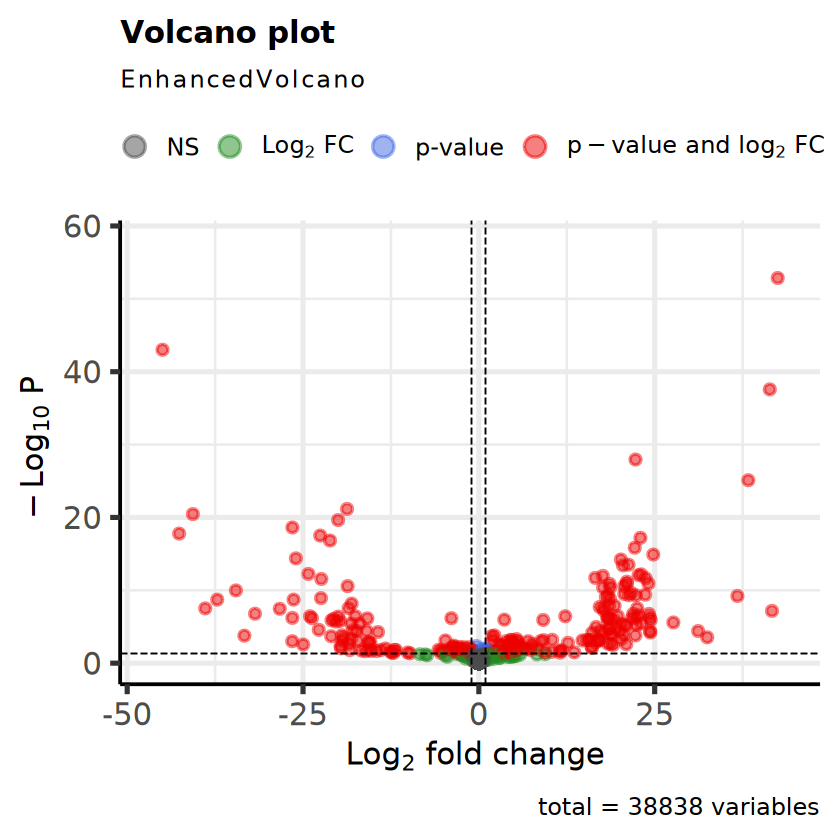

In [75]:
res.cw.ch <- lfcShrink(dds, contrast=c('complete_trtmt', 'control.warm', 'control.hypoxic'), # CH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cw.ch)

EnhancedVolcano(res.cw.ch,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cw.ch <- merge(res.cw.ch, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cw.ch)[1] <- 'Gene'

head(res.cw.ch)

In [76]:
write.csv(res.cw.ch, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cw_ch.csv')

**CB vs. CH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 114, 0.32%
LFC < -1.00 (down) : 145, 0.41%



Gene         baseMean    log2FoldChange lfcSE      stat        pvalue    
1 LOC111116054   8.9537018  0.052527169   0.25144419  2.42386441 0.01535634
2 LOC111126949 558.9188428  0.005625165   0.08832551  0.28851078 0.77295578
3 LOC111110729 112.7023690  0.011812442   0.08450879  0.41016869 0.68168220
4 LOC111112434   7.0206931  0.009137095   0.10950590  0.95634954 0.33889567
5 LOC111120752 427.4811709  0.008237753   0.08590478  0.31965724 0.74922818
6 LOC111128944   0.1058866 -0.004048836   0.58808335 -0.09723754 0.92253775
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.4032156 0.7236580   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 1.0000000 0.9826021 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 1.0000000 0.9851008  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 0.9731003 0.9662547  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 1.0000000 0.9845179 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6 1.0000000 0.9372221   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

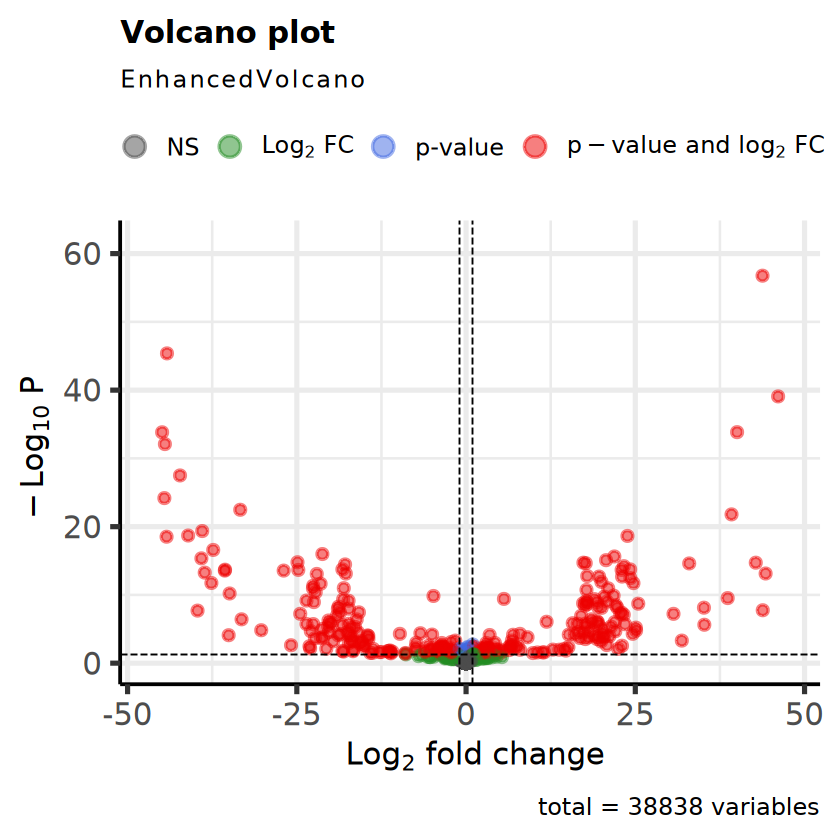

In [77]:
res.cb.ch <- lfcShrink(dds, contrast=c('complete_trtmt', 'control.both', 'control.hypoxic'), # CH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cb.ch)

EnhancedVolcano(res.cb.ch,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cb.ch <- merge(res.cb.ch, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cb.ch)[1] <- 'Gene'

head(res.cb.ch)

In [78]:
write.csv(res.cb.ch, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cb_ch.csv')

**CB vs. CW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 77, 0.22%
LFC < -1.00 (down) : 148, 0.42%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue   
1 LOC111116054   8.9537018  0.014946858   0.10703435  1.4186198 0.1560099
2 LOC111126949 558.9188428  0.003408153   0.07577701  0.2376885 0.8121227
3 LOC111110729 112.7023690 -0.031340705   0.07510722 -1.4396160 0.1499761
4 LOC111112434   7.0206931  0.004879542   0.09501384  0.6259795 0.5313284
5 LOC111120752 427.4811709 -0.009271451   0.07385524 -0.4882492 0.6253733
6 LOC111128944   0.1058866 -0.004057970   0.53121443 -0.1199177 0.9045483
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.8509416 0.9641818   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 1.0000000 0.9846545 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.8446714 0.9850075  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 1.0000000 0.9752520  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 1.0000000 0.9859905 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6 1.0000000 0.9481506   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

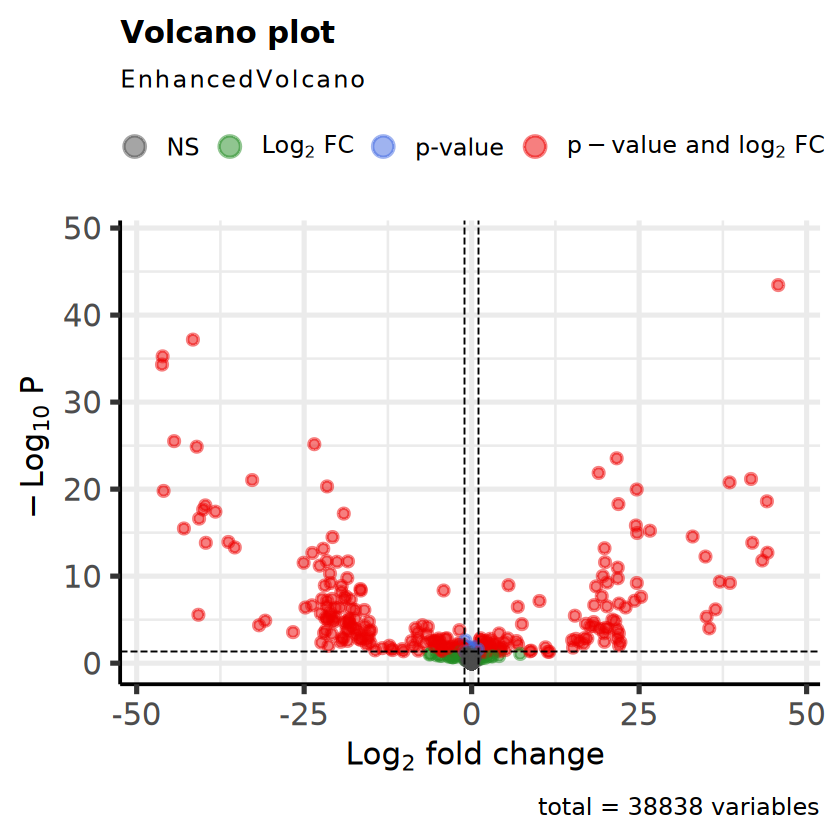

In [79]:
res.cb.cw <- lfcShrink(dds, contrast=c('complete_trtmt', 'control.both', 'control.warm'), # CW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cb.cw)

EnhancedVolcano(res.cb.cw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cb.cw <- merge(res.cb.cw, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cb.cw)[1] <- 'Gene'

head(res.cb.cw)

In [80]:
write.csv(res.cb.cw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cb_cw.csv')

### 9. Effect of the order of stressors
Does the order of when stress is experienced matter? Maybe one stressor is an informative cue for a later environmnet?
- WH vs. HW
- WB vs. BW
- HB vs. BH

**WH vs. HW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 129, 0.36%
LFC < -1.00 (down) : 79, 0.22%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue    
1 LOC111116054   8.9537018  3.713828e-04  0.03101503  0.3204937 0.74859408
2 LOC111126949 558.9188428 -3.853349e-03  0.05339287 -1.8281827 0.06752214
3 LOC111110729 112.7023690 -6.296049e-05  0.01079274 -0.1359234 0.89188184
4 LOC111112434   7.0206931  7.644970e-04  0.04305643  0.5059950 0.61286019
5 LOC111120752 427.4811709 -1.838859e-04  0.01278609 -0.3451319 0.72999519
6 LOC111128944   0.1058866  0.000000e+00  0.51033035  0.0000000 1.00000000
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1.0000000 0.9830532   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.8433554 0.9753013 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 1.0000000 0.9888748  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 1.0000000 0.9796638  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 1.0000000 0.9882065 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6 1.0000000 0.9515869   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

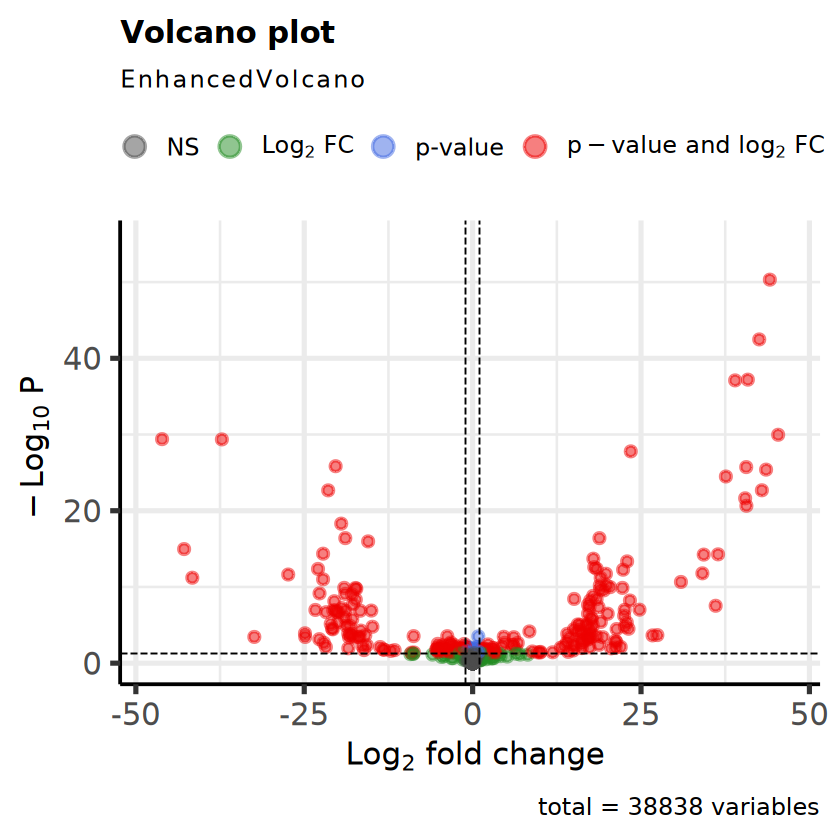

In [81]:
res.wh.hw <- lfcShrink(dds, contrast=c('complete_trtmt', 'warm.hypoxic', 'hypoxic.warm'), # HW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.wh.hw)

EnhancedVolcano(res.wh.hw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wh.hw <- merge(res.wh.hw, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wh.hw)[1] <- 'Gene'

head(res.wh.hw)

In [82]:
write.csv(res.wh.hw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wh_hw.csv')

**WB vs. BW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 186, 0.53%
LFC < -1.00 (down) : 56, 0.16%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue   
1 LOC111116054   8.9537018  0.014402062   0.11796632  0.8968419 0.3698033
2 LOC111126949 558.9188428  0.018662731   0.10216410  0.7249659 0.4684729
3 LOC111110729 112.7023690  0.016942341   0.09523466  0.4600354 0.6454908
4 LOC111112434   7.0206931 -0.002776148   0.11763608 -0.2120204 0.8320911
5 LOC111120752 427.4811709  0.046080860   0.10032152  1.3690339 0.1709887
6 LOC111128944   0.1058866  0.005431935   0.60521341  0.1236372 0.9016025
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.8878347 0.9692018   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.9183973 0.9786480 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.9593516 0.9828276  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 0.9872367 0.9725372  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.7610211 0.9793138 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6        NA 0.9399928   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

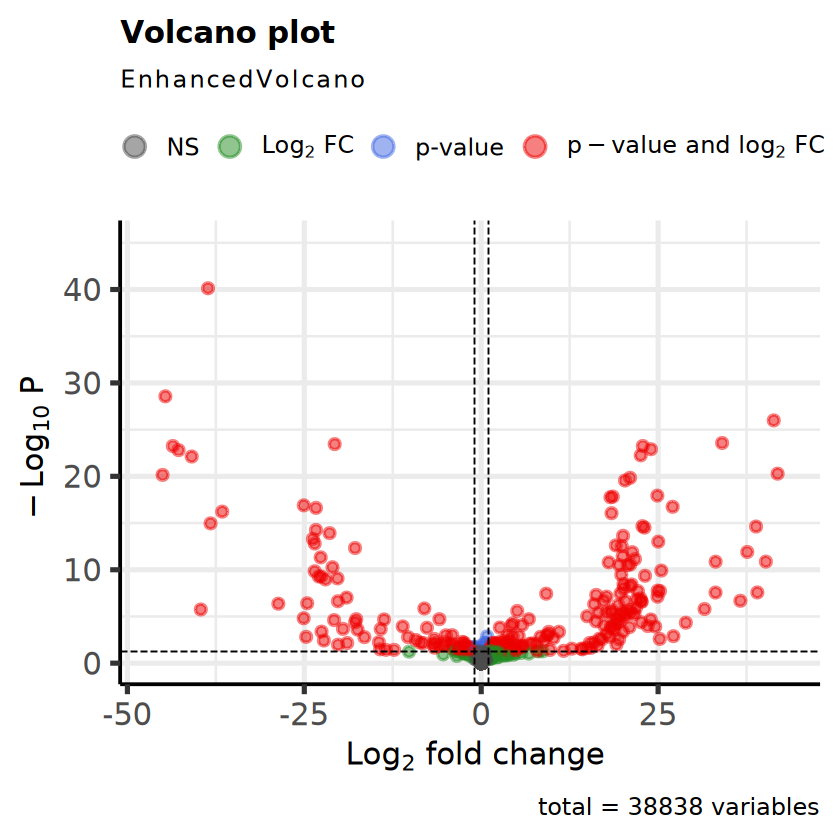

In [83]:
res.wb.bw <- lfcShrink(dds, contrast=c('complete_trtmt', 'warm.both', 'both.warm'), # BW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.wb.bw)

EnhancedVolcano(res.wb.bw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wb.bw <- merge(res.wb.bw, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wb.bw)[1] <- 'Gene'

head(res.wb.bw)

In [84]:
write.csv(res.wb.bw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wb_bw.csv')

**HB vs. BH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 271, 0.77%
LFC < -1.00 (down) : 80, 0.23%



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue     
1 LOC111116054   8.9537018 -0.01696199    0.1996602 -0.3180369 0.750456968
2 LOC111126949 558.9188428  0.07878423    0.1836710  0.9671355 0.333476306
3 LOC111110729 112.7023690 -0.06672323    0.1554205 -0.7153968 0.474363886
4 LOC111112434   7.0206931 -0.50740520    1.1221502 -3.0745303 0.002108343
5 LOC111120752 427.4811709 -0.13630884    0.1718322 -1.4382617 0.150359828
6 LOC111128944   0.1058866  0.00000000    0.7112057  0.0000000 1.000000000
  padj       svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.99028554 0.9717890   1.866636   5.925652 ⋯   4.308183   2.436697  11.10840
2 0.82741494 0.9746579 825.986574 471.089320 ⋯ 229.410737 540.946738 502.34665
3 0.90544272 0.9799764  59.732362  91.847603 ⋯ 128.168440  61.729658  86.39869
4 0.07961674 0.3471357  10.266500   1.975217 ⋯   6.462274   0.000000  13.57694
5 0.63982821 0.9764550 335.994538 331.836502 ⋯ 418.970782 284.281319 443.10184
6         NA 0.9249475   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   1.994767   7.317628   5.245991   2.287545  20.92789   1.068844   0.0000 
2 738.063823 646.695362 425.974455 478.096882 467.02232 300.345215 632.2158 
3 148.610148 110.679121 120.657789 144.115328 118.95851 135.743211 224.8113 
4   5.984301   3.658814   0.000000   2.287545  17.62348   8.550753   0.0000 
5 344.097323 400.640125 291.677090 328.262692 458.21058 355.925113 453.8444 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

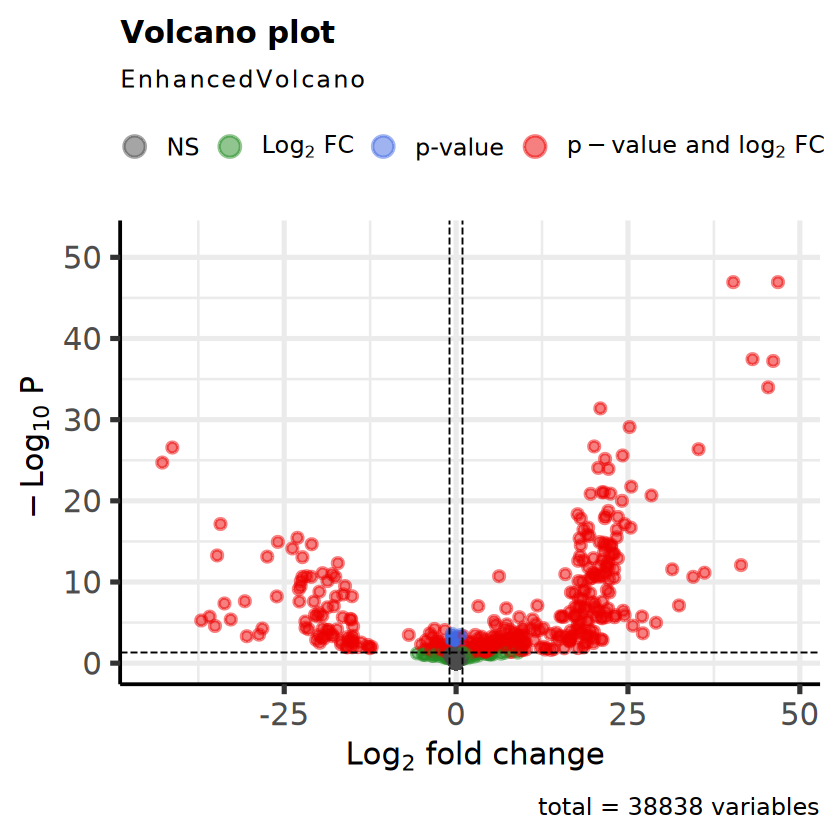

In [85]:
res.hb.bh <- lfcShrink(dds, contrast=c('complete_trtmt', 'hypoxic.both', 'both.hypoxic'), # BH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hb.bh)

EnhancedVolcano(res.hb.bh,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hb.bh <- merge(res.hb.bh, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hb.bh)[1] <- 'Gene'

head(res.hb.bh)

In [86]:
write.csv(res.hb.bh, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hb_bh.csv')